# Analysis of regional mass balance

## Input
Input csv contains records for each RGI polygon, output of `mb_parallel.py` script

In [4]:
#%matplotlib notebook
%matplotlib inline

In [5]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from imview.lib import pltlib

from osgeo import gdal
from pygeotools.lib import iolib, geolib, malib

import geopandas as gpd
import cartopy.crs as ccrs 

pd.options.display.float_format = '{:,.2f}'.format

# Spatial autocorrelation factor A

785398.1633974483


Text(0, 0.5, 'Acorf')

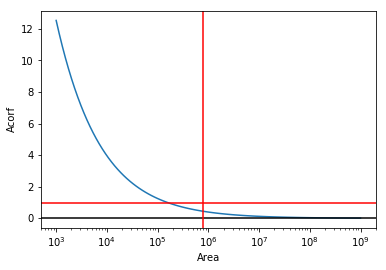

In [6]:
areaa = np.logspace(3, 9, 100)
L = 500
Acor = np.pi*(L**2)
print(Acor)
Acorf = np.sqrt(Acor/(5*areaa))
f,ax = plt.subplots()
ax.semilogx(areaa, Acorf)
ax.axhline(1.0, color='r')
ax.axhline(0.0, color='k')
ax.axvline(Acor, color='r')
ax.set_xlabel('Area')
ax.set_ylabel('Acorf')

In [163]:
def cartopy_extent(extent):
    return [extent[0], extent[2], extent[1], extent[3]]

def append_centroid_xy(df):
    xlist = []
    ylist = []
    for index, row in df.centroid.iteritems():
        xlist.append(row.x)
        ylist.append(row.y)
    df['centroid_x'] = xlist
    df['centroid_y'] = ylist

#Root sum of squared errors
def rss(a, c=0.0):
    #return ((a**2).sum() + c*a.prod())**0.5
    return ((a**2).sum())**0.5

#Root mean squared errors
def rms(a):
    return ((a**2).mean())**0.5

In [ ]:
#Define aggregation function for the dissolve
def aggregate(glac_df, glac_df_mb, col):
    aggfunc = {'area_m2':[np.mean, np.sum], \
               'mb_mwea':[np.mean, np.median, np.std, np.sum, np.size], \
               'mb_mwea_sigma':[np.mean, np.sum, rss], \
               'mb_m3wea':[np.mean, np.median, np.sum], \
               'mb_m3wea_sigma':[np.mean, np.sum, rss, rms], \
               'mb_Gta':[np.sum], \
               'mb_Gta_sigma':[np.mean, np.sum, rss, rms], \
               'Area':[np.mean, np.sum], \
               't1':[np.mean, np.min, np.max], \
               't2':[np.mean, np.min, np.max], \
               'dt':[np.mean, np.min, np.max]}
    
    #This is for all glaciers - mostly just to get total area
    glac_df_agg_sum = glac_df.groupby(col).sum()
    glac_df_agg_mean = glac_df.groupby(col).mean()
    #glac_df_agg_mean = glac_df.groupby(col).median()
    #Perform the aggregation
    glac_df_mb_agg = glac_df_mb.groupby(col).agg(aggfunc)
    
    glac_df_mb_agg[('mb_Gta','rss')] = glac_df_mb_agg[('mb_m3wea_sigma', 'rss')]/1E9
    
    #This is count of number of glaciers
    glac_df_mb_agg[('mb_mwea', 'count')] = glac_df_mb_agg[('mb_mwea', 'size')].astype('int64') 
   
    #These are values for all glaciers in each region (not just those with mb numbers)
    glac_df_mb_agg[('Area_all', 'mean')] = glac_df_agg_mean['Area']
    glac_df_mb_agg[('Area_all', 'sum')] = glac_df_agg_sum['Area']
    
    #Percent coverage of mb numbers
    glac_df_mb_agg[('Area','perc')] = 100*glac_df_mb_agg[('Area','sum')]/glac_df_mb_agg[('Area_all', 'sum')]
    glac_df_mb_agg[('mb_mwea', 'total_m3a')] = glac_df_mb_agg[('mb_mwea', 'mean')] * glac_df_mb_agg[('Area_all', 'sum')] * 1E6
    glac_df_mb_agg[('mb_mwea', 'total_Gta')] = glac_df_mb_agg[('mb_mwea', 'total_m3a')]/1E9 
    
    #Cumulative numbers for full time period
    glac_df_mb_agg[('mb_mwe_cum', 'mean')] = glac_df_mb_agg[('mb_mwea','mean')] * glac_df_mb_agg[('dt', 'mean')]
    glac_df_mb_agg[('mb_mwe_cum', 'total_m3')] = glac_df_mb_agg[('mb_mwea', 'total_m3a')] * glac_df_mb_agg[('dt', 'mean')] 
    glac_df_mb_agg[('mb_mwe_cum', 'total_Gt')] = glac_df_mb_agg[('mb_mwea', 'total_Gta')] * glac_df_mb_agg[('dt', 'mean')] 
   
    #Compute numbers for meltwater (polygons with mb < 0)
    #glac_df_mb_agg_meltwater = glac_df_mb[glac_df_mb['mb_mwea' < 0]].sum()
    glac_df_mb_agg_meltwater = glac_df_mb[glac_df_mb['mb_mwea'] < 0].groupby(col).agg(aggfunc)
    glac_df_mb_agg[('meltwater', 'count')] = glac_df_mb_agg_meltwater[('mb_mwea', 'size')].astype('int64') 
    glac_df_mb_agg[('meltwater', 'total_m3a')] = glac_df_mb_agg_meltwater[('mb_m3wea', 'sum')]
    glac_df_mb_agg[('meltwater', 'total_Gta')] = glac_df_mb_agg[('meltwater', 'total_m3a')]/1E9 
    glac_df_mb_agg[('meltwater', 'total_mmSLEa')] = glac_df_mb_agg[('meltwater', 'total_Gta')]/Gt2mm
    
    #Cumulative meltwater numbers for full time period
    glac_df_mb_agg[('meltwater_cum', 'total_m3')] = glac_df_mb_agg[('meltwater', 'total_m3a')] * glac_df_mb_agg[('dt', 'mean')] 
    glac_df_mb_agg[('meltwater_cum', 'total_Gt')] = glac_df_mb_agg[('meltwater', 'total_Gta')] * glac_df_mb_agg[('dt', 'mean')] 
    glac_df_mb_agg[('meltwater_cum', 'total_mmSLE')] = glac_df_mb_agg[('meltwater', 'total_Gta')] * glac_df_mb_agg[('dt', 'mean')] 
    return glac_df_mb_agg

In [101]:
def spatial_aggregate(glac_df, glac_df_mb, agg_df, col, sort=True):
    glac_df_mb_agg = aggregate(glac_df, glac_df_mb, col)
    append_centroid_xy(agg_df)
    if 'basin' in col:
        #Preserve basin attributes (endorheic flag, discharge)
        glac_df_mb_agg = glac_df_mb_agg.merge(agg_df[['ENDO', 'centroid_x', 'centroid_y']], left_index=True, right_index=True)
    else:
        glac_df_mb_agg = glac_df_mb_agg.merge(agg_df[['centroid_x', 'centroid_y']], left_index=True, right_index=True)
    if sort:
        glac_df_mb_agg.sort_values(by=('Area_all', 'sum'), ascending=False, inplace=True)
    glac_df_mb_agg.df_name = col
    return glac_df_mb_agg

In [9]:
def add_legend(ax, sf=16, loc='upper right'):
    """
    Create legend for scaled scatterplot markers
    """
    ax.autoscale(False)
    #CONUS
    #leg_s = np.array([0.1, 0.5, 1.0, 5.0, 10.0])
    #HMA
    #leg_s = np.array([0.1, 1.0, 10.0, 100.0])
    leg_s = np.array([1.0, 10.0, 100.0, 1000.0, 10000.0])
    #Spoof dummy coordinates way off map
    leg_x = np.full(leg_s.size, -999999999)
    leg_y = np.full(leg_s.size, -999999999)
    for i, s in enumerate(leg_s):
        #lbl = r'$%0.1f\/km^2$' % s
        lbl = '%i' % s
        ax.scatter(leg_x[i], leg_y[i], s=s*sf, c='gray', label=lbl)
    legend = ax.legend(title=r'$Glacier\/Area\/(km^2)$', scatterpoints=1, loc=loc, prop={'size':7}, ncol=leg_s.size)
    legend.get_title().set_fontsize('8')
    return legend

In [65]:
def make_map(mb_dissolve_df=None, glac_df_mb=None, agg_df=None, col=('mb_mwea', 'mean'), border_df=None, crs=None,\
             extent=None, hs=None, hs_extent=None, clim=None, labels='val', title=None):

    fig, ax = plt.subplots(figsize=(10,8))
    ax.set_aspect('equal')
    legend = add_legend(ax, sf=scaling_f)
    if title is not None:
        ax.set_title(title)

    if clim is None:
        #clim = (glac_df_mb[col].min(), glac_df_mb[col].max())
        clim = malib.calcperc_sym(mb_dissolve_df[col], perc=(1,99))

    cmap = 'RdBu'
    if 'mb_mwea' in col:
        label = 'Mass Balance (m we/yr)'
    elif 'mb_Gta' in col: 
        label = 'Mass Balance (Gt/yr)'
    elif 'mb_Gta_sigma' in col:
        cmap = 'inferno'
        label = 'Mass Balance Uncertainty (Gt/yr)'
    elif 'meltwater' in col: 
        label = 'Excess Meltwater Runoff (Gt/yr)'
        #Reverse, as these are negative values
        cmap = 'YlOrRd_r'
        #cmap = 'inferno'
        clim = malib.calcperc(mb_dissolve_df[col], perc=(0,99))
    elif 't1' in col:
        cmap = 'inferno'
        label = 'Source Date (year)'

    #This is cartopy-enabled axes
    #ax = plt.axes(projection=crs)

    #Currently unsupported for AEA
    #gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    if hs is not None:
        print("Plotting image")
        hs_style = {'cmap':'gray', 'origin':'upper', 'extent':cartopy_extent(hs_extent), 'transform':crs}
        ax.imshow(hs, **hs_style)

    if border_df is not None:
        print("Plotting borders")
        border_style = {'facecolor':'0.65','edgecolor':'k', 'linewidth':0.7}
        border_df.plot(ax=ax, **border_style)

    if False:
        if agg_df is not None:
            print("Plotting agg boundaries")
            #This provides colored regions
            #agg_style = {'cmap':'cpt_rainbow', 'edgecolor':'none', 'linewidth':0, 'alpha':0.05}
            agg_style = {'cmap':'summer', 'edgecolor':'none', 'linewidth':0, 'alpha':0.05}
            #agg_style = {'facecolor':'0.95','edgecolor':'k', 'linewidth':0.3, 'alpha':0.2}
            agg_df.plot(ax=ax, **agg_style)

    if glac_df_mb is not None:
        print("Plotting glacier polygons")
        glac_style = {'edgecolor':'k', 'linewidth':0.1, 'alpha':0.3}
        #This plots mb color ramp for each glacier polygon
        #glac_ax = glac_df_mb.plot(ax=ax, column=col[0], cmap=cmap, vmin=clim[0], vmax=clim[1], **glac_style)
        #This plots outlines
        glac_ax = glac_df_mb.plot(ax=ax, facecolor='none', **glac_style)

    if agg_df is not None:
        agg_style = {'facecolor':'none', 'edgecolor':'w', 'linewidth':0.5}
        agg_df.plot(ax=ax, **agg_style)

    #https://stackoverflow.com/questions/36008648/colorbar-on-geopandas
    # fake up the array of the scalar mappable so we can plot colorbar. Urgh...
    sc = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=clim[0], vmax=clim[1]))
    sc._A = []

    if mb_dissolve_df is not None:
        print("Plotting scatterplot of %s values" % (col, ))
        #Plot single values for region or basin
        x = mb_dissolve_df['centroid_x']
        y = mb_dissolve_df['centroid_y']
        #Scale by total glacier area in each polygon 
        s = scaling_f*mb_dissolve_df[('Area_all', 'sum')]
        c = mb_dissolve_df[col]
        sc_style = {'cmap':cmap, 'edgecolor':'k', 'linewidth':0.5, 'alpha':0.8}
        sc = ax.scatter(x, y, s, c, vmin=clim[0], vmax=clim[1], **sc_style) 
        #Add labels
        text_kw = {'family':'sans-serif', 'fontsize':10, 'color':'k'}
        if labels is not None:
            print("Adding annotations")
            for k, v in mb_dissolve_df.iterrows():
                #lbl = '%0.2f +/- %0.2f' % (v[col], v[(col[0]+'_sigma',col[1])])
                if labels == 'name+val':
                    lbl = '%s\n%+0.2f' % (k, v[col])
                else:
                    lbl = '%+0.2f' % v[col]
                #ax.annotate(lbl, xy=(v['centroid_x'],v['centroid_y']), xytext=(1,0), textcoords='offset points', family='sans-serif', fontsize=6, color='darkgreen')
                txt = ax.annotate(lbl, xy=(v['centroid_x'],v['centroid_y']), ha='center', va='center', **text_kw)
                txt.set_path_effects([path_effects.Stroke(linewidth=0.75, foreground='w'),path_effects.Normal()])

    #This is minx, miny, maxx, maxy
    if extent is None:
        #if glac_df_mb is not None:
        #    extent = glac_df_mb.total_bounds
        #else:
        extent = mb_dissolve_df.total_bounds

    #For cartopy axes
    #ax.set_extent(cartopy_extent(extent), crs=crs)
    #Pad extent so labels fit within map
    #extent = geolib.pad_extent(extent, perc=0.01, uniform=True)
    ax.set_xlim(extent[0], extent[2])
    ax.set_ylim(extent[1], extent[3])

    #Adding colorbar doesn't work with the cartopy axes
    pltlib.add_cbar(ax, sc, arr=mb_dissolve_df[col], label=label, clim=clim)
    pltlib.add_scalebar(ax, res=1)
    pltlib.hide_ticks(ax)

    plt.tight_layout()

    return fig

In [11]:
site = 'hma'
#site = 'conus'

area_filter = False
min_area_m2 = 1E6

outlier_removal = False

#Ocean area
#3.625×108 km2 (Cogley et al., 2011)
Gt2mm = 362.5

plot = True 
map_plots = True 

#Default mb clim
#mb_clim = (-1.0, 1.0)
#mb_clim = (-1.2, 1.2)
mb_clim = (-0.75, 0.75)

#suptitle = "Glacier Mass Balance (ASTER 2000–2009)"
suptitle = "Glacier Mass Balance (ASTER+WV/GE 2000–2018)"
#suptitle = "Glacier Mass Balance (ASTER 2009–2018)"
#suptitle = "Glacier Mass Balance (SRTM 2000 to WV/GE median)"

#HMA
scaling_f = 0.2 
#CONUS
#scaling_f = 3 

rgi_col = 'RGIId'
kaab_region_col = 'kaab_region'
region_col = 'himap_region'
basin_col = 'HYBAS_ID'
qdgc_col = 'qdgc'
mascon_col = 'mascon'
hex_col = 'id'

extent = None
crs = None
if site == 'hma':
    basin_col = 'basin_name'
    hs_fn = '/Users/dshean/Documents/UW/HMA/mos/hma_mos_32m_20180723/hma_mos_32m_100m_hs_az315.tif'
    glac_shp_fn = '/Users/dshean/data/rgi60/regions/rgi60_merge_HMA_aea.shp'
    #glac_shp_fn = '/Users/dshean/data/rgi60/regions/rgi60_merge_HMA_aea_0.1km.shp'
    #glac_shp_fn = '/Users/dshean/data/rgi60/regions/rgi60_merge_HMA_aea_1km.shp'
    border_shp_fn = '/Users/dshean/data/NaturalEarth/10m_cultural/10m_cultural/ne_10m_admin_0_countries_lakes.shp'
    #basin_shp_fn = '/Users/dshean/data/HydroBASINS/hybas_lake_as_lev01-12_v1c/hybas_lake_as_lev04_v1c.shp'
    basin_shp_fn = '/Users/dshean/data/HydroBASINS/HiMAT_full_210_IDs_subset_merged_clip_names_update.gpkg'
    #region_shp_fn = '/Users/dshean/Documents/UW/HMA/Kaab_regions/regions_from_kaab2015_merged_clean.shp'
    kaab_region_shp_fn = '/Users/dshean/data/Kaab_regions/regions_from_kaab2015_merged_clean_20181111.gpkg'
    region_shp_fn = '/Users/dshean/data/himap_regions/boundary_mountain_regions_hma_v3_clean.gpkg'
    #http://www.mindland.com/wp/download-qdgc-continents/
    qdgc_shp_fn = '/Users/dshean/data/qdgc/qdgc_asia/qdgc_01_asia.shp'
    mascon_shp_fn = '/Users/dshean/data/grace_mascons/GSFC.glb.200301_201607_v02.4_clip.gpkg'
    hex_shp_fn = '/Users/dshean/data/hma_hexagons/hma_25km_hexagons.gpkg'
    #This is geopandas crs format
    glac_crs = {u'datum':u'WGS84',u'lat_0':36,u'lat_1':25,u'lat_2':47,u'lon_0':85,u'no_defs':True,u'proj':u'aea',u'units':u'm',u'x_0':0,u'y_0':0}
    #minx, miny, maxx, maxy
    extent = [-1610900, -1142400, 1767400, 1145700]
elif site == 'conus':
    #hs_fn = '/scr/mb/gpd/conus_20171018_mos_32m_trans_100m_hs_az315_1km.tif'
    glac_shp_fn = '/Users/dshean/data/rgi60/regions/rgi60_merge_CONUS_aea.shp'
    #region_shp_fn = '/Users/dshean/Documents/UW/CONUS/regions/conus_mb_regions.shp'
    region_shp_fn = '/Users/dshean/data/CONUS/regions/conus_mb_regions_aea.shp'
    border_shp_fn = '/Users/dshean/data/NaturalEarth/10m_cultural/10m_cultural/ne_10m_admin_1_states_provinces_lakes.shp'
    basin_shp_fn = '/Users/dshean/data/HydroBASINS/hybas_lake_na_lev01-12_v1c/hybas_lake_na_lev07_v1c.shp'
    glac_crs = {u'datum':u'WGS84',u'lat_0':43,u'lat_1':36,u'lat_2':49,u'lon_0':-115,u'no_defs':True,u'proj':u'aea',u'units':u'm',u'x_0':0,u'y_0':0}
    #This is cartopy
    crs = ccrs.AlbersEqualArea(central_longitude=-115, central_latitude=43, standard_parallels=(36, 49))
    extent = [-856800, -789000, 910700, 839400]
else:
    sys.exit("Site not currently supported")

In [12]:
def proc_rgi(glac_shp_fn, pointgeom=True):
    glac_df = gpd.read_file(glac_shp_fn)
    glac_df.shape
    glac_df.set_index(rgi_col, inplace=True)
    #Add centroid field - needed for proper partitioning in spatial join
    if pointgeom:
        glac_df['centroid_geom'] = gpd.GeoSeries(glac_df.centroid)
        glac_df['polygon_geom'] = gpd.GeoSeries(glac_df.geometry)
        glac_df.set_geometry('centroid_geom', inplace=True, drop=True)
    return glac_df

In [13]:
wgs84_fn = '/Users/dshean/data/rgi60/regions/rgi60_merge_HMA.shp'
aea_proj = '+proj=aea +lat_1=25 +lat_2=47 +lat_0=36 +lon_0=85 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs '
wgs84_gdf = proc_rgi(wgs84_fn, pointgeom=False)

In [14]:
aea_gdf = wgs84_gdf.to_crs(aea_proj)

In [15]:
aea_gdf.head()

,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,Zmax,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
RGIId,,,,,,,,,,,,,,,,,,,,,
RGI60-13.00001,G079494E34471N,20000810,-9999999,79.49,34.47,13,5,0.43,5678,5928,...,312,683,0,0,0,0,9,9,None,POLYGON ((-496209.4980626574 -158466.015012046...
RGI60-13.00002,G077951E35545N,20020802,-9999999,77.95,35.55,13,5,0.37,5889,6217,...,195,1307,0,0,0,0,9,9,None,POLYGON ((-626705.1167637523 -28600.2744567913...
RGI60-13.00003,G077930E35519N,20020802,-9999999,77.93,35.52,13,5,0.07,5646,5849,...,318,426,0,0,0,0,9,9,None,POLYGON ((-629301.7064239474 -31756.2054540928...
RGI60-13.00004,G077924E35525N,20020802,-9999999,77.92,35.53,13,5,0.26,5698,5850,...,39,605,0,0,0,0,9,9,None,"POLYGON ((-630269.84028706 -30936.45473942306,..."
RGI60-13.00005,G077914E35531N,20020802,-9999999,77.91,35.53,13,5,0.26,5644,5809,...,8,389,0,0,0,0,9,9,None,POLYGON ((-630048.1153940231 -30657.6697324176...


# Generate 500-m buffer around RGI polygons and dissolve

#rgi_gdf_buff = aea_gdf.buffer(500)
rgi_gdf_buff.head()
rgi_gdf_buff_gdf = gpd.GeoDataFrame(rgi_gdf_buff, crs=aea_gdf.crs, geometry=rgi_gdf_buff)

rgi_gdf_buff_gdf = gpd.GeoDataFrame(rgi_gdf_buff, crs=aea_gdf.crs)

rgi_gdf_buff_gdf.set_geometry(rgi_gdf_buff_gdf[0], inplace=True)

rgi_gdf_buff_gdf['temp'] = 'asdf'
rgi_gdf_buff_gdf.head()
buff_poly = rgi_gdf_buff_gdf.dissolve(by='temp')

rgi_area = buff_poly.area.iloc[0]
print('%0.0f' % (rgi_area/1E6))

buff_area = buff_poly.area.iloc[0]
print('%0.0f' % (buff_area/1E6))

In [20]:
#Input csv from mb_parallel.py
#mb_csv_fn = sys.argv[1]
#mb_csv_fn = "/scr/hma/mb_20181108/ASTER_2000-2018/hma_mb_20181108_0454.csv"
#mb_csv_fn = "/scr/hma/mb_20181211/hma_mb_20181211_2117.csv"
#mb_csv_fn = "/scr/hma/mb_20181222/hma_mb_20181211_2117.csv"
#mb_csv_fn = "/scr/hma/mb_20190207/hma_mb_20190207_0856.csv"
#mb_csv_fn = "/scr/hma/mb_20190212/hma_mb_20190213_0143.csv"
#This is std
#mb_csv_fn = "/scr/hma/mb_20190213/hma_mb_20190213_1924.csv"
#This is nmad
#mb_csv_fn = "/scr/hma/mb_20190213_nmad/hma_mb_20190214_1015.csv"
#This is std + mean
mb_csv_fn = "/scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean.csv"
#Copy for hex analysis
mb_csv_fn = "/scr/hma/mb_20190213_std_sys_hex/hma_mb_20190215_0815_std+mean.csv"

#driver = 'GeoJSON'
#ext = 'geojson'
#driver = 'ESRI Shapefile'
#ext = 'shp'
driver = 'GPKG'
ext= 'gpkg'

merge_fn = os.path.splitext(mb_csv_fn)[0]+'_'+os.path.splitext(os.path.split(glac_shp_fn)[-1])[0]+'.'+ext

glac_shp_join_fn = os.path.splitext(merge_fn)[0]+'_join.'+ext

if os.path.exists(glac_shp_join_fn):
    print("Loading glacier polygons joined with regions, basins, qdgc, mascons")
    glac_df = gpd.read_file(glac_shp_join_fn)
    #This is a hack, as geojson doesn't properly preserve custom aae proj
    glac_df.crs = glac_crs
else:
    print("Loading glacier polygons from RGI")
    glac_df = proc_rgi(glac_shp_fn)

#Area in km2
#glac_df.geometry.area.sum()/1E6
#glac_df['Area'].sum()

if kaab_region_shp_fn is not None:
    print("Loading Kaab regions")
    kaab_region_df = gpd.read_file(kaab_region_shp_fn)
    #Convert to glac crs
    kaab_region_df = kaab_region_df.to_crs(glac_df.crs)
    kaab_region_df.set_index(kaab_region_col, inplace=True)

if region_shp_fn is not None:
    print("Loading regions")
    region_df = gpd.read_file(region_shp_fn)
    #Convert to glac crs
    region_df = region_df.to_crs(glac_df.crs)
    region_df.set_index(region_col, inplace=True)

if basin_shp_fn is not None:
    print("Loading basins")
    basin_df = gpd.read_file(basin_shp_fn)
    #There are issues with fiona writing large integers in basin IDs, convert to string to be safe
    #The dtype is int64, but finoa writes int32, and they all get truncated to 2147483647
    if basin_col == 'HYBAS_ID':
        for f in ['HYBAS_ID', 'NEXT_DOWN', 'NEXT_SINK', 'MAIN_BAS']:
            basin_df[f] = basin_df[f].astype('str')
    #Convert to glac crs
    basin_df = basin_df.to_crs(glac_df.crs)
    basin_df.set_index(basin_col, inplace=True)

if mascon_shp_fn is not None:
    print("Loading mascon")
    mascon_df = gpd.read_file(mascon_shp_fn)
    #Convert to glac crs
    mascon_df = mascon_df.to_crs(glac_df.crs)
    #Add a unique identifier
    mascon_df[mascon_col] = mascon_df.lat_center.map('{:,.0f}N'.format) + mascon_df.lon_center.map('{:,.0f}E'.format)
    mascon_df.set_index(mascon_col, inplace=True)

if qdgc_shp_fn is not None:
    print("Loading qdgc")
    qdgc_df = gpd.read_file(qdgc_shp_fn)
    #Convert to glac crs
    qdgc_df = qdgc_df.to_crs(glac_df.crs)
    qdgc_df.set_index(qdgc_col, inplace=True)
    
if hex_shp_fn is not None:
    print("Loading hex")
    hex_df = gpd.read_file(hex_shp_fn)
    #Convert to glac crs
    hex_df = hex_df.to_crs(glac_df.crs)
    hex_df.set_index(hex_col, inplace=True)

print(glac_df.shape)
#Add region, basin, etc fields to RGI polygons
if not os.path.exists(glac_shp_join_fn):
    if mascon_shp_fn is not None:
        print("One-time spatial join by mascon")
        glac_df = gpd.sjoin(glac_df, mascon_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':mascon_col}, inplace=True)
        print(glac_df.shape)

    if qdgc_shp_fn is not None:
        print("One-time spatial join by qdgc")
        glac_df = gpd.sjoin(glac_df, qdgc_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':qdgc_col}, inplace=True)
        print(glac_df.shape)
    
    if hex_shp_fn is not None:
        print("One-time spatial join by hex")
        glac_df = gpd.sjoin(glac_df, hex_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':hex_col}, inplace=True)
        print(glac_df.shape)

    if kaab_region_shp_fn is not None:
        print("One-time spatial join by Kaab region")
        glac_df = gpd.sjoin(glac_df, kaab_region_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':kaab_region_col}, inplace=True)
        print(glac_df.shape)
        
    if region_shp_fn is not None:
        print("One-time spatial join by region")
        glac_df = gpd.sjoin(glac_df, region_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':region_col}, inplace=True)
        print(glac_df.shape)

    if basin_shp_fn is not None:
        print("One-time spatial join by basin")
        glac_df = gpd.sjoin(glac_df, basin_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':basin_col}, inplace=True)
        print(glac_df.shape)

    glac_df.set_geometry('polygon_geom', inplace=True, drop=True)
    print("Writing out: %s" % glac_shp_join_fn)
    #With index set to RGIId, it is not written out, hack to create new column
    glac_df.reset_index().rename(columns={'index':rgi_col}).to_file(glac_shp_join_fn, driver=driver)

Loading glacier polygons from RGI
Loading Kaab regions
Loading regions
Loading basins
Loading mascon
Loading qdgc
Loading hex
(95608, 23)
One-time spatial join by mascon
(95604, 33)
One-time spatial join by qdgc
(95604, 37)
One-time spatial join by hex
(95591, 42)
One-time spatial join by Kaab region
(94827, 43)
One-time spatial join by region
(94827, 44)
One-time spatial join by basin
(94827, 47)
Writing out: /scr/hma/mb_20190213_std_sys_hex/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join.gpkg


/Users/dshean/sw/miniconda3/envs/shean_py3/lib/python3.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [21]:
rgi_count = 95608 - 72 #some RGI 10 included
rgi_count

95536

In [22]:
print("Loading mb")
mb_df = pd.read_csv(mb_csv_fn)
mb_df[rgi_col] = 'RGI60-'+mb_df[rgi_col].map('{:08.5f}'.format)
mb_df.set_index(rgi_col, inplace=True)
mb_df['mb_Gta'] = mb_df['mb_m3wea']/1E9
mb_df['mb_Gta_sigma'] = mb_df['mb_m3wea_sigma']/1E9
mb_df_t1 = mb_df['t1'].mean()
mb_df_t2 = mb_df['t2'].mean()
print(mb_df_t1, mb_df_t2)
dt_str = '%.0f-%.0f' % (mb_df_t1, mb_df_t2)

#mb_df['mb_mwea_area'] = mb_df['mb_mwea'] * mb_df['area_km2']*1E6

if os.path.exists(merge_fn):
    print("Loading merged polygons and mb")
    glac_df_mb = gpd.read_file(merge_fn)
    glac_df_mb.set_index(rgi_col, inplace=True)
    print(glac_df_mb.shape)
else:
    print("Merging glacier polygons and mb results")
    glac_df_mb = glac_df.merge(mb_df, left_index=True, right_index=True)
    #With index set to RGIId, it is not written out, hack to create new column
    print(glac_df_mb.shape)
    print("Writing out: %s" % merge_fn)
    glac_df_mb.reset_index().rename(columns={'index':rgi_col}).to_file(merge_fn, driver=driver)

print("%i merged records loaded" % (glac_df_mb.shape[0]))

if area_filter:
    print("Filtering by glacier polygon area (min %0.2f km^2)" % (min_area_m2/1E6))
    orig_count = glac_df_mb.shape[0]
    glac_df_mb = glac_df_mb[glac_df_mb['area_m2'] > min_area_m2]
    print("%i of %i records preserved" % (glac_df_mb.shape[0], orig_count))

Loading mb
2000.4119999999998 2018.4119999999998
Merging glacier polygons and mb results
(94436, 72)
Writing out: /scr/hma/mb_20190213_std_sys_hex/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea.gpkg
94436 merged records loaded


In [23]:
#glac_df_mb_buffer = glac_df_mb.buffer(1000)

In [24]:
glac_df_mb.area.sum()

97002698226.10503

In [25]:
glac_df_mb_sort = glac_df_mb.sort_values(by='area_m2', ascending=False)

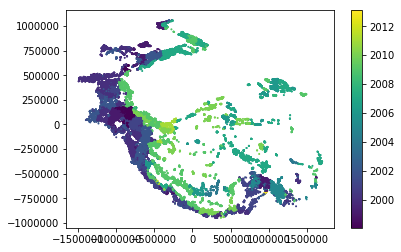

In [27]:
#RGI polygon date
f,ax = plt.subplots()
sc = ax.scatter(glac_df_mb_sort['x'], glac_df_mb_sort['y'], c=glac_df_mb_sort['BgnDate'].astype(int)/10000, s=1)
plt.colorbar(sc)
#glac_df_mb_sort.plot.scatter(x='x', y='y', c='BgnDate')

In [28]:
pd.set_option('display.max_columns', 500)

In [29]:
rgi_idx = glac_df_mb_sort['mb_m3wea'].idxmax()

In [30]:
glac_df_mb_sort.loc[rgi_idx]

GLIMSId                                               G075438E36192N
BgnDate                                                     19980813
EndDate                                                     -9999999
CenLon                                                         75.44
CenLat                                                         36.19
O1Region                                                          14
O2Region                                                           2
Area                                                          203.34
Zmin                                                            3314
Zmax                                                            7718
Zmed                                                            5391
Slope                                                          23.60
Aspect                                                            21
Lmax                                                           31640
Status                            

In [31]:
#mb_m3wea_sigma_thresh = glac_df_mb_sort['mb_m3wea_sigma'].quantile(0.99)
#glac_df_mb_sort = glac_df_mb_sort[glac_df_mb_sort['mb_m3wea_sigma'] < mb_m3wea_sigma_thresh]

In [32]:
glac_df_mb_sort['mb_m3wea_sigma']/glac_df_mb_sort['mb_m3wea']

RGI60-14.07524    -4.75
RGI60-14.06794    32.97
RGI60-13.54431    -0.51
RGI60-14.00005    -0.88
RGI60-14.04477     0.94
RGI60-14.05890    -0.20
RGI60-14.04593    -0.27
RGI60-13.05000    -0.16
RGI60-13.43207    -4.17
RGI60-14.04668    -2.06
RGI60-14.02150    -0.17
RGI60-14.04638    -0.33
RGI60-13.43483    -0.68
RGI60-14.07239    -3.36
RGI60-13.53720    -0.18
RGI60-13.37753    -0.17
RGI60-14.04404     0.53
RGI60-14.06580     1.59
RGI60-13.37682    -1.60
RGI60-14.01823    -0.25
RGI60-14.07794    -1.55
RGI60-15.11909    -0.20
RGI60-14.04411    -0.55
RGI60-13.43528    -0.80
RGI60-14.04291    -0.78
RGI60-13.53223    -0.38
RGI60-13.43613    -0.85
RGI60-13.13574    -0.35
RGI60-14.08555    -0.29
RGI60-13.43252    -0.65
                  ...  
RGI60-13.53052    -9.83
RGI60-13.28208    -0.56
RGI60-13.28283    -1.16
RGI60-13.32174     0.58
RGI60-13.28193     4.61
RGI60-13.28697    -0.65
RGI60-13.51804    -1.77
RGI60-15.08734    -0.56
RGI60-13.53120    -1.15
RGI60-14.26606     4.56
RGI60-13.28406  

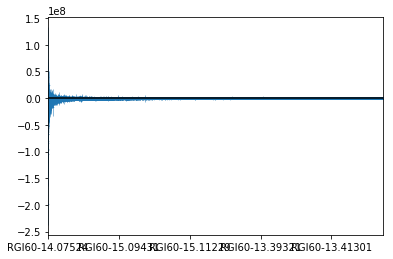

In [33]:
f, ax = plt.subplots()
glac_df_mb_sort['mb_m3wea'].plot(marker='.', markersize=1, ls='none', lw=0.5, yerr=glac_df_mb_sort['mb_m3wea_sigma'], ax=ax)
ax.axhline(0, color='k', zorder=99)

In [34]:
test2 = glac_df_mb_sort['mb_m3wea_sigma'][0:2]
c=0.5
np.sqrt((test2**2).sum() + c*test2.prod())/1E9

0.1259740280054272

In [35]:
test2.prod()

6081635134254274.0

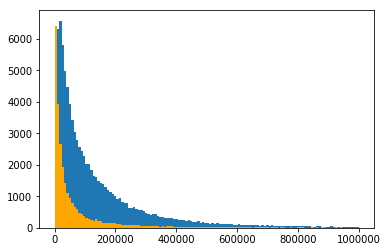

In [36]:
f, ax = plt.subplots()
asdf = ax.hist(glac_df_mb_sort['mb_m3wea_sigma'], bins=128, range=(0,1E6))
asdf = ax.hist(glac_df_mb_sort['mb_m3wea'], bins=128, range=(0,1E6), color='orange')
#mb_df['mb_m3wea'].hist(bins=128, range=(0,1E6),ax=ax)

In [37]:
idx = slice(0,100000)
print(glac_df_mb_sort['mb_m3wea'].iloc[idx].sum()/1E9)
print(rss(glac_df_mb_sort['mb_m3wea_sigma'].iloc[idx])/1E9)
print(glac_df_mb_sort['mb_m3wea_sigma'][idx].sum()/1E9)

-18.975358849018
nan
21.524032616649993


/Users/dshean/sw/miniconda3/envs/shean_py3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


In [38]:
rgi_count_perc = 100.*glac_df_mb.shape[0]/rgi_count
print("%i of %i total RGI polygons: %0.2f%%" % (glac_df_mb.shape[0], rgi_count, rgi_count_perc))

94436 of 95536 total RGI polygons: 98.85%


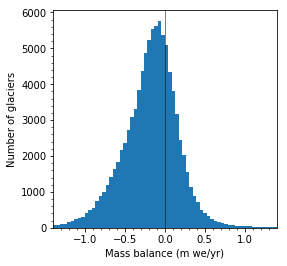

In [39]:
f, ax = plt.subplots(figsize=(4,4))
ax.set_xlabel('Mass balance (m we/yr)')
ax.set_ylabel('Number of glaciers')
hist_clim = (-1.4, 1.4)
ax.set_xlim(*hist_clim)
glac_df_mb['mb_mwea'].hist(range=hist_clim, bins=64, grid=False)
ax.axvline(0, lw=0.5, color='k')
ax.minorticks_on()

In [40]:
if outlier_removal:
    print("Removing outliers")

    #outlier_perc = (0.01, 0.99)
    outlier_perc = (0.001, 0.999)
    #outlier_clim = (glac_df_mb['mb_mwea'].quantile(outlier_perc[0]), glac_df_mb['mb_mwea'].quantile(outlier_perc[1]))
    std_f = 3.5
    #outlier_clim = glac_df_mb['mb_mwea'].mean() - std_f*glac_df_mb['mb_mwea'].std()
    outlier_clim = glac_df_mb['mb_mwea'].median() - std_f*malib.mad(glac_df_mb['mb_mwea'].values)
    outlier_clim = (outlier_clim, -outlier_clim)
    print("Removing outliers (%0.2f, %0.2f)" % (outlier_clim))
    #inlier_idx = np.abs(glac_df_mb['mb_mwea'] - glac_df_mb['mb_mwea'].mean()) <= (3*glac_df_mb['mb_mwea'].std())
    inlier_idx = (glac_df_mb['mb_mwea'] >= outlier_clim[0]) & (glac_df_mb['mb_mwea'] <= outlier_clim[1])

    print("%i records before outlier removal" % (glac_df_mb.shape[0]))
    glac_df_mb = glac_df_mb[inlier_idx]
    print("%i records after outlier removal" % (glac_df_mb.shape[0]))

    if False:
        glac_df_mb['mb_mwea'].hist(range=hist_clim, bins=256, label='After outlier filter')
        ax.axvline(0, linewidth=0.5, color='k')
        ax.legend()

In [41]:
test = aggregate(glac_df, glac_df_mb, 'Status')

/Users/dshean/sw/miniconda3/envs/shean_py3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


In [42]:
test.T

Status                                        0
area_m2        mean                1,027,179.23
               sum            97,002,698,226.23
mb_mwea        mean                       -0.18
               median                     -0.15
               std                         0.38
               sum                   -17,169.20
               size                   94,436.00
mb_mwea_sigma  mean                        0.38
               sum                    36,321.22
               rss                       151.26
mb_m3wea       mean                 -200,933.53
               median                -25,197.92
               sum           -18,975,358,849.02
mb_m3wea_sigma mean                  227,921.90
               sum            21,524,032,616.65
               rss                          nan
               rms                 1,059,118.25
mb_Gta         sum                       -18.98
mb_Gta_sigma   mean                        0.00
               sum                        21.52
               rss                         0.33
               rms                         0.00
Area           mean                        1.03
               sum                    97,002.78
t1             mean                    2,000.41
               amin                    2,000.41
               amax                    2,000.41
t2             mean                    2,018.41
               amin                    2,018.41
               amax                    2,018.41
dt             mean                       18.00
               amin                       18.00
               amax                       18.00
mb_Gta         rss                          nan
mb_mwea        count                  94,436.00
Area_all       mean                        1.03
               sum                    97,300.12
Area           perc                       99.69
mb_mwea        total_m3a     -17,689,916,404.47
               total_Gta                 -17.69
mb_mwe_cum     mean                       -3.27
               total_m3     -318,418,495,280.53
               total_Gt                 -318.42
meltwater      count                  66,504.00
               total_m3a     -22,735,690,310.50
               total_Gta                 -22.74
               total_mmSLEa               -0.06
meltwater_cum  total_m3     -409,242,425,588.95
               total_Gt                 -409.24
               total_mmSLE              -409.24

In [43]:
test[('mb_m3wea_sigma','mean')] * test[('mb_mwea','count')]

Status
0   21,524,032,616.65
dtype: float64

In [44]:
glac_df_mb.describe()

,CenLon,CenLat,Area,Zmin,Zmax,Zmed,Slope,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,area_deg,area_km2,basin,elev_flag,lat_center,lat_span,location,lon_center,lon_span,id,left,top,right,bottom,DN,ENDO,x,y,z_med,z_min,z_max,z_slope,z_aspect,dhdt_ma,dhdt_ma_sigma,mb_mwea,mb_mwea_sigma,area_m2,mb_m3wea,mb_m3wea_sigma,t1,t2,dt,valid_area_perc,H_m,debris_m,perc_debris,perc_pond,perc_clean,vm_ma,mb_Gta,mb_Gta_sigma
count,"94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","94,436.00","8,025.00","7,880.00","8,025.00","8,025.00","8,025.00","7,717.00","94,436.00","94,436.00"
mean,81.11,35.52,1.03,"4,856.40","5,307.79","5,082.02",25.91,171.64,"1,220.09",0.00,0.00,0.02,0.00,7.20,8.93,1.00,"12,391.12","5,245.26",0.00,35.52,1.00,80.00,81.11,1.24,"5,042.48","-343,123.54","-6,430.58","-314,256.02","-31,430.58","4,299.33",0.52,"-328,729.82","-18,918.09","5,055.50","4,830.32","5,292.32",26.87,168.96,-0.21,0.45,-0.18,0.38,"1,027,179.23","-200,933.53","227,921.90","2,000.41","2,018.41",18.00,99.51,60.84,0.17,12.53,0.16,87.31,3.35,-0.00,0.00
std,7.98,4.38,7.75,694.80,704.81,681.92,7.77,130.38,"1,752.04",0.00,0.00,0.15,0.00,3.59,0.78,0.00,11.77,410.09,0.00,4.39,0.00,0.00,7.99,0.07,"2,931.72","711,088.43","498,575.49","711,088.43","498,575.49","5,186.84",0.50,"711,130.99","498,497.10",685.86,697.42,708.75,8.73,115.26,0.45,0.36,0.38,0.31,"7,747,064.71","1,664,001.52","1,034,308.65",0.00,0.00,0.00,1.69,22.94,0.07,14.43,0.36,14.63,4.71,0.00,0.00
min,67.48,27.49,0.01,521.00,"1,141.00",610.00,-9.00,-9.00,-9.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,"12,373.54","5,004.00",0.00,27.00,1.00,80.00,67.74,1.12,298.00,"-1,492,334.00","-940,759.92","-1,463,466.49","-965,759.92",11.00,0.00,"-1,488,027.43","-950,447.98","2,866.82","2,289.59","3,050.73",2.03,4.75,-7.40,0.01,-6.29,0.02,"10,017.13","-198,383,836.77",768.50,"2,000.41","2,018.41",18.00,85.00,24.01,0.01,0.00,0.00,1.29,0.21,-0.20,0.00
25%,75.07,31.81,0.10,"4,347.00","4,828.00","4,605.00",20.20,40.00,432.00,0.00,0.00,0.00,0.00,9.00,9.00,1.00,"12,380.52","5,007.00",0.00,32.00,1.00,80.00,74.85,1.18,"2,811.00","-886,116.22","-428,259.92","-857,248.71","-453,259.92","1,270.00",0.00,"-864,263.20","-438,552.40","4,585.75","4,328.88","4,816.29",20.18,56.09,-0.45,0.24,-0.38,0.21,"96,333.46","-122,638.95","33,621.62","2,000.41","2,018.41",18.00,99.07,45.82,0.14,2.99,0.00,83.47,1.09,-0.00,0.00
50%,78.71,35.84,0.23,"4,950.00","5,426.00","5,194.00",25.30,156.00,728.00,0.00,0.00,0.00,0.00,9.00,9.00,1.00,"12,392.33","5,035.00",0.00,36.00,1.00,80.00,78.88,1.24,"4,116.00","-561,356.69","34,240.08","-532,489.18","9,240.08","3,546.00",1.00,"-557,373.75","21,709.09","5,163.87","4,924.08","5,406.90",26.48,146.63,-0.18,0.37,-0.15,0.31,"231,949.66","-25,197.92","86,064.49","2,000.41","2,018.41",18.00,99.82,55.55,0.17,7.51,0.03,92.41,1.98,-0.00,0.00
75%,86.28,38.44,0.63,"5,396.00","5,847.00","5,620.00",31.00,311.00,"1,355.00",0.00,0.00,0.00,0.00,9.00,9.00,1.00,"12,401.62","5,051.00",0.00,38.00,1.00,80.00,85.98,1.27,"6,871.00","109,812.99","359,240.08","138,680.51","334,240.08","5,367.00",1.00,"116,283.35","344,098.36","5,596.18","5,368.18","5,835.34",33.08,292.67,0.04,0.55,0.04,0.47,"628,779.32","4,823.91","200,788.72","2,000.41","2,018.41",18.00,100.19,69.09,0.20,16.30,0.17,96.98,3.80,0.00,0.00
max,103.15,45.35,"1,077.96","7,624.00","8,799.00","7,828.00",69.50,360.00,"76,460.00",0.00,0.00,1.00,0.00,9.00,9.00,1.00,"12,413.85","6,019.00",0.00,45.00,1.00,80.00,103.44,1.42,"13,416.00","1,690,309.36","1,071,

In [45]:
if kaab_region_shp_fn is not None:
    glac_df_mb_kaab_region = spatial_aggregate(glac_df, glac_df_mb, kaab_region_df, kaab_region_col)

/Users/dshean/sw/miniconda3/envs/shean_py3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/dshean/sw/miniconda3/envs/shean_py3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [46]:
if region_shp_fn is not None:
    glac_df_mb_region = spatial_aggregate(glac_df, glac_df_mb, region_df, region_col)

/Users/dshean/sw/miniconda3/envs/shean_py3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


In [47]:
glac_df_mb_kaab_region.iloc[1]

(area_m2, mean)                        767,280.46
(area_m2, sum)                  13,485,721,385.91
(mb_mwea, mean)                             -0.20
(mb_mwea, median)                           -0.17
(mb_mwea, std)                               0.30
(mb_mwea, sum)                          -3,567.17
(mb_mwea, size)                         17,576.00
(mb_mwea_sigma, mean)                        0.28
(mb_mwea_sigma, sum)                     4,940.69
(mb_mwea_sigma, rss)                        43.69
(mb_m3wea, mean)                      -171,623.83
(mb_m3wea, median)                     -23,864.06
(mb_m3wea, sum)                 -3,016,460,417.07
(mb_m3wea_sigma, mean)                 158,224.19
(mb_m3wea_sigma, sum)            2,780,948,339.68
(mb_m3wea_sigma, rss)                         nan
(mb_m3wea_sigma, rms)                1,220,674.05
(mb_Gta, sum)                               -3.02
(mb_Gta_sigma, mean)                         0.00
(mb_Gta_sigma, sum)                          2.78


In [48]:
glac_df_mb_kaab_region[[('Area_all', 'sum'),('mb_Gta', 'sum'),('mb_Gta_sigma', 'sum'),('mb_Gta', 'rss')]]

,"(Area_all, sum)","(mb_Gta, sum)","(mb_Gta_sigma, sum)","(mb_Gta, rss)"
kaab_region,,,,
Karakoram,"20,237.82",-0.81,2.76,nan
Inner TP,"13,536.96",-3.02,2.78,nan
Tien Shan,"12,099.78",-3.53,3.42,nan
Kunlun,"10,419.00",0.49,1.52,nan
Spiti Lahaul,"7,743.00",-2.46,1.82,nan
Pamir,"7,097.66",-0.80,1.03,nan
Nyainqentangla,"6,944.06",-3.51,2.96,nan
Hindu Kush,"5,324.42",-0.45,1.25,nan
Central Himalaya,"4,969.56",-1.81,1.27,nan


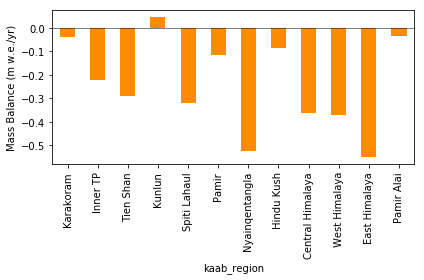

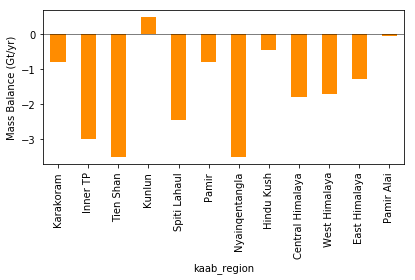

In [49]:
%matplotlib inline
mb_tot = glac_df_mb_kaab_region[('mb_m3wea', 'sum')]
DOF=1
#err = glac_df_mb_kaab_region[('mb_m3wea_sigma', 'sum')]/DOF
err = glac_df_mb_kaab_region[('mb_m3wea_sigma', 'rss')]

fig, ax = plt.subplots()
(mb_tot/glac_df_mb_kaab_region[('area_m2', 'sum')]).plot.bar(yerr=err/glac_df_mb_kaab_region[('area_m2', 'sum')], ax=ax, color='darkorange', error_kw=dict(ecolor='k', lw=1, capsize=2, capthick=1))
ax.axhline(0, color='k', lw=0.5)
ax.set_ylabel('Mass Balance (m w.e./yr)')
plt.tight_layout()
fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_kaab_region_mwea_bar.png'
fig.savefig(fig_fn, dpi=300, pad_inches=0) 

fig, ax = plt.subplots()
(mb_tot/1E9).plot.bar(yerr=err/1E9, ax=ax, color='darkorange', error_kw=dict(ecolor='k', lw=1, capsize=2, capthick=1))
ax.axhline(0, color='k', lw=0.5)
ax.set_ylabel('Mass Balance (Gt/yr)')
plt.tight_layout()
fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_kaab_region_Gta_bar.png'
fig.savefig(fig_fn, dpi=300, pad_inches=0) 

In [102]:
if mascon_shp_fn is not None:
    glac_df_mb_mascon = spatial_aggregate(glac_df, glac_df_mb, mascon_df, mascon_col)

if qdgc_shp_fn is not None:
    glac_df_mb_qdgc = spatial_aggregate(glac_df, glac_df_mb, qdgc_df, qdgc_col)

if hex_shp_fn is not None:
    glac_df_mb_hex = spatial_aggregate(glac_df, glac_df_mb, hex_df, hex_col, sort=False)
    
if basin_shp_fn is not None:
    glac_df_mb_basin = spatial_aggregate(glac_df, glac_df_mb, basin_df, basin_col)
    glac_df_mb_basin_exo = glac_df_mb_basin[glac_df_mb_basin['ENDO'] == 0]

/Users/dshean/sw/miniconda3/envs/shean_py3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


In [51]:
#Compile stats for all glaciers
#specific mass balance rate and total mass change  
all_stats = glac_df_mb[['mb_mwea','mb_m3wea']].mean()
#all_stats = glac_df_mb[['mb_mwea','mb_m3wea']].median()
all_stats['mb_mwea_std'] = glac_df_mb[['mb_mwea','mb_mwea']].std()
all_stats['mb_m3wea_std'] = glac_df_mb[['mb_mwea','mb_m3wea']].std()
#glac_df_mb[['mb_mwea','mb_m3wea']].apply(malib.mad, axis=0)
#all_stats = glac_df_mb[['mb_mwea']].mean()
#Total sampled area
all_stats['sample_area'] = glac_df_mb['Area'].sum()
#All area in RGI db
all_stats['RGI_total_area'] = glac_df['Area'].sum()
all_stats['sample_area_perc'] = all_stats['sample_area']/all_stats['RGI_total_area']
all_stats['mb_m3wea_sum'] = glac_df_mb['mb_m3wea'].sum()
all_stats['mb_m3wea_sigma_mean'] = glac_df_mb['mb_m3wea_sigma'].mean()
all_stats['mb_m3wea_sigma_rss'] = rss(glac_df_mb['mb_m3wea_sigma'])
all_stats['mb_m3wea_sigma_rms'] = rms(glac_df_mb['mb_m3wea_sigma'])
all_stats['mb_m3wea_sigma_sum'] = glac_df_mb['mb_m3wea_sigma'].sum()
all_stats['mb_m3wea_all'] = all_stats['mb_mwea'] * all_stats['RGI_total_area'] * 1E6
all_stats['mb_Gta'] = all_stats['mb_m3wea']/1E9
all_stats['mb_Gta_sum'] = all_stats['mb_m3wea_sum']/1E9
all_stats['mb_Gta_sigma_rss'] = all_stats['mb_m3wea_sigma_rss']/1E9
all_stats['mb_Gta_sigma_rms'] = all_stats['mb_m3wea_sigma_rms']/1E9
all_stats['mb_Gta_all'] = all_stats['mb_m3wea_all']/1E9
all_stats['mma_SLR'] = all_stats['mb_Gta_sum']/Gt2mm

print(all_stats['mb_m3wea_sum']/(all_stats['sample_area']*1E6))
print(all_stats['mb_m3wea_sigma_rss']/(all_stats['sample_area']*1E6))

dt = glac_df_mb['dt'].mean()
all_stats_cum = all_stats * dt

print("All glaciers, rate")
print(all_stats)
#print("All glaciers, cumulative")
#print(all_stats_cum)

-0.19561664177615776
nan
All glaciers, rate
mb_mwea                                                            -0.18
mb_m3wea                                                     -200,933.53
mb_mwea_std                 mb_mwea   0.38
mb_mwea   0.38
dtype: float64
mb_m3wea_std           mb_mwea            0.38
mb_m3wea   1,664,001.5...
sample_area                                                    97,002.78
RGI_total_area                                                 97,300.12
sample_area_perc                                                    1.00
mb_m3wea_sum                                          -18,975,358,849.02
mb_m3wea_sigma_mean                                           227,921.90
mb_m3wea_sigma_rss                                                   NaN
mb_m3wea_sigma_rms                                          1,059,118.25
mb_m3wea_sigma_sum                                     21,524,032,616.65
mb_m3wea_all                                          -17,689,916,404.47
mb_Gta 

/Users/dshean/sw/miniconda3/envs/shean_py3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


In [52]:
L = 500
n = len(glac_df_mb)
#sigma_rms = all_stats['mb_m3wea_sigma_rms']
#np.sqrt(n)*(5**2)*sigma_rms/1E9
#np.sqrt(n)*sigma_rms/1E9

In [53]:
n = 30
all_stats['mb_m3wea_sigma_sum']/1E9/np.sqrt(n)

3.9297327308720496

In [54]:
region_col = [('mb_mwea', 'count'),('mb_mwea', 'mean'),('mb_mwea', 'std'),('Area', 'sum'),('Area_all', 'sum'),('Area', 'perc'),('mb_mwea', 'total_Gta'), ('mb_Gta', 'sum'), ('mb_Gta', 'rss')]

kaab_region_summary = glac_df_mb_kaab_region[region_col]
display(kaab_region_summary)
out_fn = os.path.splitext(glac_shp_join_fn)[0]+'__%s_kaab_region_summary.pkl' % dt_str
kaab_region_summary.to_pickle(out_fn)

region_summary = glac_df_mb_region[region_col]
display(region_summary)
out_fn = os.path.splitext(glac_shp_join_fn)[0]+'__%s_region_summary.pkl' % dt_str
region_summary.to_pickle(out_fn)

basin_summary = glac_df_mb_basin[[('meltwater', 'count'),('meltwater', 'total_m3a'),('meltwater', 'total_Gta'),('meltwater', 'total_mmSLEa'), ('Area_all', 'sum')]]
display(basin_summary)
print(glac_df_mb_basin[[('meltwater', 'total_Gta'),('meltwater', 'total_mmSLEa')]].sum())
out_fn = os.path.splitext(glac_shp_join_fn)[0]+'__%s_basin_summary.pkl' % dt_str
basin_summary.to_pickle(out_fn)

print("\nExorheic Basins (SLR contribution)")
display(glac_df_mb_basin_exo[[('meltwater', 'count'),('meltwater', 'total_m3a'),('meltwater', 'total_Gta'),('meltwater', 'total_mmSLEa')]])
print(glac_df_mb_basin_exo[[('meltwater', 'total_Gta'),('meltwater', 'total_mmSLEa')]].sum())

#Compile stats for each division
print("\nTotal Gt/a for each aggregation")
print('agg', 'total_Gta', 'mb_mwea')
for i in [glac_df_mb_basin, glac_df_mb_region, glac_df_mb_qdgc]:
    print(i.df_name, i[('mb_Gta', 'sum')].sum(), i['mb_mwea', 'mean'].mean())

if False:
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    print("Loading shaded relief map")
    hs_ds = gdal.Open(hs_fn)
    hs = iolib.ds_getma(hs_ds)
    hs_extent = geolib.ds_extent(hs_ds)
    hs_extent_cartopy = cartopy_extent(hs_extent)
    print("Plotting image")
    ax.imshow(hs, cmap='gray', origin='upper', extent=hs_extent_cartopy, transform=crs, alpha=0.6)
else:
    hs = None

"""
#This is currently broken
import cartopy.feature as cfeature
borders = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='50m', facecolor='none')
ax.add_feature(borders, edgecolor='k')
"""

,"(mb_mwea, count)","(mb_mwea, mean)","(mb_mwea, std)","(Area, sum)","(Area_all, sum)","(Area, perc)","(mb_mwea, total_Gta)","(mb_Gta, sum)","(mb_Gta, rss)"
kaab_region,,,,,,,,,
Karakoram,10279,-0.02,0.30,"20,229.01","20,237.82",99.96,-0.34,-0.81,nan
Inner TP,17576,-0.20,0.30,"13,485.70","13,536.96",99.62,-2.75,-3.02,nan
Tien Shan,14314,-0.28,0.42,"12,097.05","12,099.78",99.98,-3.44,-3.53,nan
Kunlun,6639,0.12,0.23,"10,415.62","10,419.00",99.97,1.20,0.49,nan
Spiti Lahaul,9956,-0.20,0.26,"7,741.51","7,743.00",99.98,-1.52,-2.46,nan
Pamir,7081,-0.06,0.20,"7,097.05","7,097.66",99.99,-0.41,-0.80,nan
Nyainqentangla,7278,-0.46,0.60,"6,727.96","6,944.06",96.89,-3.20,-3.51,nan
Hindu Kush,7430,-0.05,0.32,"5,324.23","5,324.42",100.00,-0.27,-0.45,nan
Central Himalaya,3896,-0.36,0.32,"4,960.26","4,969.56",99.81,-1.79,-1.81,nan


,"(mb_mwea, count)","(mb_mwea, mean)","(mb_mwea, std)","(Area, sum)","(Area_all, sum)","(Area, perc)","(mb_mwea, total_Gta)","(mb_Gta, sum)","(mb_Gta, rss)"
himap_region,,,,,,,,,
Karakoram,11528,-0.00,0.34,"21,466.66","21,475.66",99.96,-0.02,-0.77,nan
Central Himalaya,7310,-0.35,0.32,"8,658.11","8,668.87",99.88,-3.00,-3.25,nan
Western Kunlun Shan,5666,0.11,0.22,"8,452.57","8,455.74",99.96,0.95,0.38,nan
Western Pamir,9083,-0.06,0.20,"8,420.22","8,420.83",99.99,-0.52,-0.96,nan
Western Himalaya,9841,-0.20,0.27,"7,967.11","7,968.60",99.98,-1.59,-2.54,nan
Central Tien Shan,5832,-0.20,0.39,"7,269.26","7,270.83",99.98,-1.48,-1.64,nan
Nyainqentanglha,7249,-0.42,0.59,"6,826.79","7,044.99",96.90,-2.96,-3.33,nan
Tibetan Interior Mountains,3478,-0.09,0.19,"3,807.36","3,816.98",99.75,-0.35,-0.44,nan
Eastern Kunlun Shan,3083,-0.02,0.25,"2,990.88","2,995.00",99.86,-0.06,-0.24,nan


,"(meltwater, count)","(meltwater, total_m3a)","(meltwater, total_Gta)","(meltwater, total_mmSLEa)","(Area_all, sum)"
basin_name,,,,,
Indus,15999,"-4,517,100,722.39",-4.52,-0.01,"27,295.00"
Tarim,7940,"-2,516,167,875.13",-2.52,-0.01,"21,854.22"
Brahmaputra,9756,"-5,347,943,006.36",-5.35,-0.01,"10,367.66"
Amu_Darya,7591,"-1,357,949,562.92",-1.36,-0.00,"10,078.52"
Ganges,6028,"-3,154,709,634.29",-3.15,-0.01,"8,426.07"
Inner_Tibetan_Plateau,3388,"-1,166,812,154.15",-1.17,-0.00,"6,334.99"
Ili,5593,"-1,755,848,520.47",-1.76,-0.00,"4,408.68"
Inner_Tibetan_Plateau_Extended,3121,"-773,122,002.29",-0.77,-0.00,"2,959.07"
Syr_Darya,3053,"-556,178,059.97",-0.56,-0.00,"2,340.81"


(meltwater, total_Gta)      -22.74
(meltwater, total_mmSLEa)    -0.06
dtype: float64

Exorheic Basins (SLR contribution)


,"(meltwater, count)","(meltwater, total_m3a)","(meltwater, total_Gta)","(meltwater, total_mmSLEa)"
basin_name,,,,
Indus,15999,"-4,517,100,722.39",-4.52,-0.01
Brahmaputra,9756,"-5,347,943,006.36",-5.35,-0.01
Ganges,6028,"-3,154,709,634.29",-3.15,-0.01
Yangtze,1367,"-675,425,643.28",-0.68,-0.00
Salween,2105,"-768,922,031.52",-0.77,-0.00
Mekong,324,"-79,026,158.77",-0.08,-0.00
Yellow,110,"-33,355,506.95",-0.03,-0.00
Irrawady,129,"-33,129,432.01",-0.03,-0.00


(meltwater, total_Gta)      -14.61
(meltwater, total_mmSLEa)    -0.04
dtype: float64

Total Gt/a for each aggregation
agg total_Gta mb_mwea
basin_name -18.97535884901799 -0.3031722602217072
himap_region -18.975358849017994 -0.2202520247001697
qdgc -18.975358849018 -0.2182991763935569


"\n#This is currently broken\nimport cartopy.feature as cfeature\nborders = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='50m', facecolor='none')\nax.add_feature(borders, edgecolor='k')\n"

In [55]:
if True:
    mascon_df_out = glac_df_mb_mascon[[('mb_mwea','count'),('mb_mwea', 'mean'), ('mb_mwea', 'std'), ('Area','sum'),('mb_Gta', 'sum'), ('Area_all', 'sum'), ('mb_mwea', 'total_Gta')]]
    header = ('n_glaciers','mb_mwea_mean','mb_mwea_std','obs_glacier_area_km2','mb_Gta_sum','all_glacier_area_km2','mb_Gta_all')
    mascon_csv_fn = os.path.splitext(glac_shp_join_fn)[0]+'_mascon.csv'
    mascon_df_out.to_csv(mascon_csv_fn, float_format='%0.2f',header=header)

In [56]:
map_plots=True

In [57]:
if border_shp_fn is not None:
    print("Loading borders")
    #Load local copy of border polygons
    border_df = gpd.read_file(border_shp_fn)
    border_df = border_df.to_crs(glac_df.crs)

Loading borders


Generating figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_basin_excess_Gt_fig.png
Plotting borders
Plotting agg boundaries
Plotting glacier polygons
Plotting scatterplot of ('meltwater', 'total_Gta') values
Adding annotations
Saving figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_basin_excess_Gt_fig.png


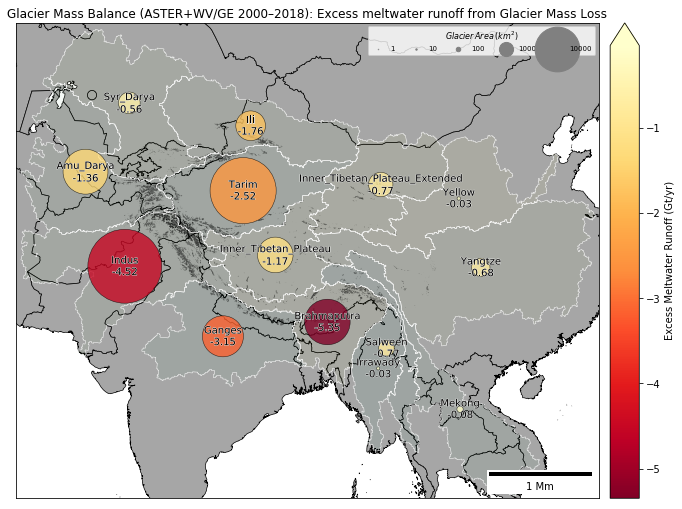

In [69]:
if map_plots and basin_shp_fn is not None:
    basin_melt_gt_clim = (-5, 0)
    basin_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_basin_excess_Gt_fig.png'
    print("Generating figure: %s" % basin_fig_fn)
    if basin_col == 'HYBAS_ID':
        title = suptitle + ": HydroBASINS level 4" 
    else:
        title = suptitle + ": Excess meltwater runoff from Glacier Mass Loss"
    #minx, miny, maxx, maxy
    basin_extent = [-2396534,-2619071, 3273634,2008000]
    #basin_extent = basin_df.total_bounds
    basin_fig = make_map(col=('meltwater', 'total_Gta'), mb_dissolve_df=glac_df_mb_basin, glac_df_mb=glac_df_mb, agg_df=basin_df, border_df=border_df, clim=basin_melt_gt_clim, crs=crs, extent=basin_extent, labels='name+val', title=title)
    #basin_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_basin, glac_df_mb=glac_df_mb, agg_df=basin_df, border_df=border_df, clim=None, crs=crs, extent=extent, labels='val', title=title)
    print("Saving figure: %s" % basin_fig_fn)
    #basin_fig.savefig(basin_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 
    basin_fig.savefig(basin_fig_fn, dpi=300, pad_inches=0) 

Generating figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_basin_mwe_fig.png
Plotting borders
Plotting agg boundaries
Plotting glacier polygons
Plotting scatterplot of ('mb_mwea', 'mean') values
Adding annotations
Saving figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_basin_mwe_fig.png


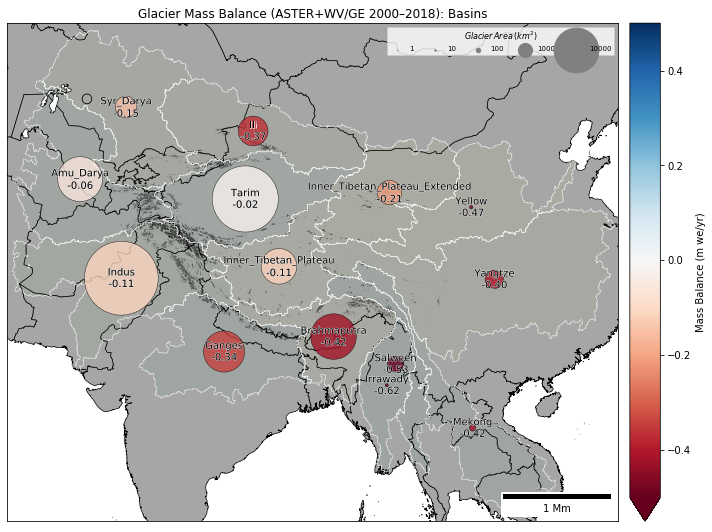

In [70]:
if map_plots and basin_shp_fn is not None:
    basin_mb_clim = (-0.5, 0.5)
    basin_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_basin_mwe_fig.png'
    print("Generating figure: %s" % basin_fig_fn)
    if basin_col == 'HYBAS_ID':
        title = suptitle + ": HydroBASINS level 4" 
    else:
        title = suptitle + ": Basins"
    #minx, miny, maxx, maxy
    basin_extent = [-2396534,-2619071, 3273634,2008000]
    basin_fig = make_map(col=('mb_mwea', 'mean'), mb_dissolve_df=glac_df_mb_basin, glac_df_mb=glac_df_mb, agg_df=basin_df, border_df=border_df, clim=basin_mb_clim, crs=crs, extent=basin_extent, labels='name+val', title=title)
    print("Saving figure: %s" % basin_fig_fn)
    #basin_fig.savefig(basin_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 
    basin_fig.savefig(basin_fig_fn, dpi=300, pad_inches=0) 

Generating figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_qdgc_mwe_fig.png
Plotting borders
Plotting glacier polygons
Plotting scatterplot of ('mb_mwea', 'mean') values
Saving figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_qdgc_mwe_fig.png


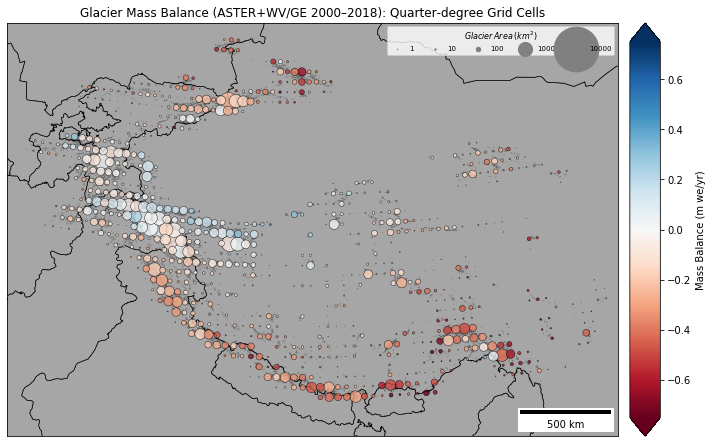

In [71]:
if map_plots and qdgc_shp_fn is not None:
    qdgc_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_qdgc_mwe_fig.png'
    print("Generating figure: %s" % qdgc_fig_fn)
    #To plot grid cells, pass agg_df=qdgc_df
    title = suptitle + ": Quarter-degree Grid Cells"
    qdgc_fig = make_map(col=('mb_mwea', 'mean'), mb_dissolve_df=glac_df_mb_qdgc, glac_df_mb=glac_df_mb, agg_df=None, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels=None, title=title)
    print("Saving figure: %s" % qdgc_fig_fn)
    qdgc_fig.savefig(qdgc_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 

Plotting borders
Plotting scatterplot of ('mb_Gta', 'sum') values


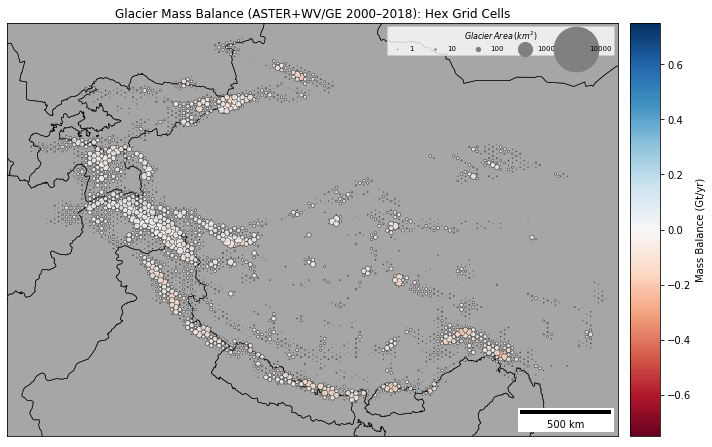

In [96]:
if map_plots and hex_shp_fn is not None:
    #hex_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_hex_mwe_fig.png'
    #print("Generating figure: %s" % hex_fig_fn)
    #To plot grid cells, pass agg_df=qdgc_df
    title = suptitle + ": Hex Grid Cells"
    hex_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels=None, title=title)
    #print("Saving figure: %s" % hex_fig_fn)
    #hex_fig.savefig(hex_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 

In [97]:
glac_df_mb_hex[('mb_Gta', 'sum')].describe()

count   2,422.00
mean       -0.01
std         0.02
min        -0.27
25%        -0.01
50%        -0.00
75%        -0.00
max         0.08
Name: (mb_Gta, sum), dtype: float64

In [98]:
glac_df_mb_hex[('mb_Gta_sigma', 'sum')].describe()

count   2,422.00
mean        0.01
std         0.01
min         0.00
25%         0.00
50%         0.00
75%         0.01
max         0.17
Name: (mb_Gta_sigma, sum), dtype: float64

Plotting borders
Plotting scatterplot of ('mb_Gta', 'sum') values


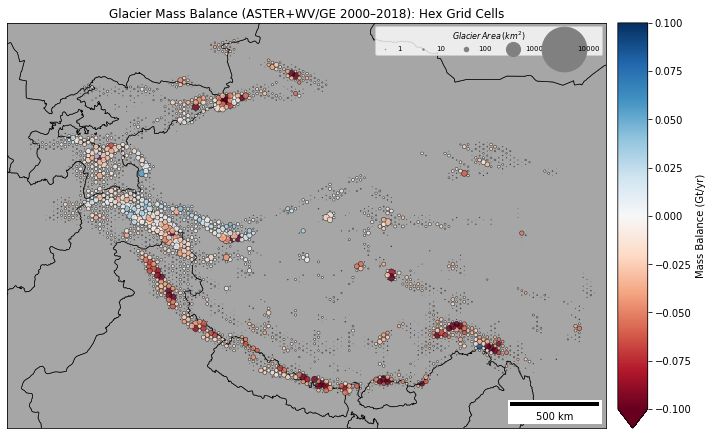

In [70]:
mb_gt_clim = (-0.1,0.1)
hex_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_gt_clim, crs=crs, extent=extent, labels=None, title=title)

Plotting borders
Plotting scatterplot of ('mb_Gta_sigma', 'sum') values


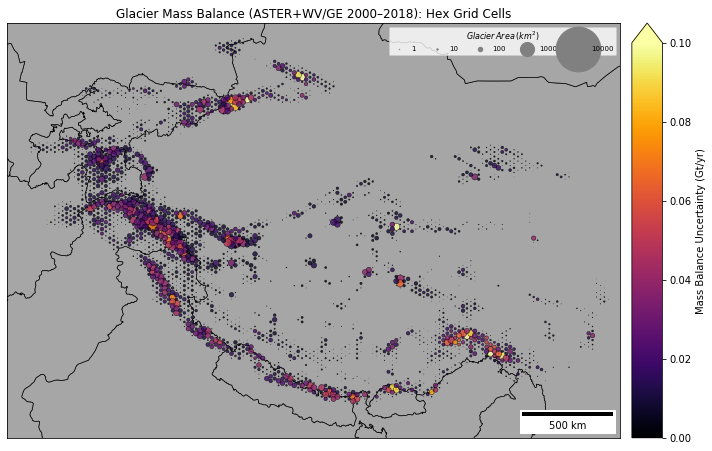

In [67]:
sigma_clim = (0,0.1)
hex_fig = make_map(col=('mb_Gta_sigma', 'sum'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=sigma_clim, crs=crs, extent=extent, labels=None, title=title)

In [103]:
glac_df_mb_hex

,"(area_m2, mean)","(area_m2, sum)","(mb_mwea, mean)","(mb_mwea, median)","(mb_mwea, std)","(mb_mwea, sum)","(mb_mwea, size)","(mb_mwea_sigma, mean)","(mb_mwea_sigma, sum)","(mb_mwea_sigma, rss)","(mb_m3wea, mean)","(mb_m3wea, median)","(mb_m3wea, sum)","(mb_m3wea_sigma, mean)","(mb_m3wea_sigma, sum)","(mb_m3wea_sigma, rss)","(mb_m3wea_sigma, rms)","(mb_Gta, sum)","(mb_Gta_sigma, mean)","(mb_Gta_sigma, sum)","(mb_Gta_sigma, rss)","(mb_Gta_sigma, rms)","(Area, mean)","(Area, sum)","(t1, mean)","(t1, amin)","(t1, amax)","(t2, mean)","(t2, amin)","(t2, amax)","(dt, mean)","(dt, amin)","(dt, amax)","(mb_Gta, rss)","(mb_mwea, count)","(Area_all, mean)","(Area_all, sum)","(Area, perc)","(mb_mwea, total_m3a)","(mb_mwea, total_Gta)","(mb_mwe_cum, mean)","(mb_mwe_cum, total_m3)","(mb_mwe_cum, total_Gt)","(meltwater, count)","(meltwater, total_m3a)","(meltwater, total_Gta)","(meltwater, total_mmSLEa)","(meltwater_cum, total_m3)","(meltwater_cum, total_Gt)","(meltwater_cum, total_mmSLE)",centroid_x,centroid_y
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
298,"169,212.88","1,184,490.18",-0.47,-0.49,0.44,-3.27,7.00,0.78,5.45,2.20,"-90,281.80","-83,700.68","-631,972.57","113,462.37","794,236.56","333,278.42","125,967.40",-0.00,0.00,0.00,0.00,0.00,0.17,1.18,"2,000.41","2,000.41","2,000.41","2,018.41","2,018.41","2,018.41",18.00,18.00,18.00,0.00,7,0.17,1.18,100.00,"-552,968.00",-0.00,-8.41,"-9,953,424.00",-0.01,6.00,"-652,500.79",-0.00,-0.00,"-11,745,014.18",-0.01,-0.01,"-1,477,900.25","484,240.08"
299,"219,009.30","6,351,269.62",-0.24,-0.23,0.40,-7.10,29.00,0.84,24.42,5.15,"-54,182.09","-31,491.63","-1,571,280.58","170,939.94","4,957,258.28","1,496,737.45","277,937.17",-0.00,0.00,0.00,0.00,0.00,0.22,6.35,"2,000.41","2,000.41","2,000.41","2,018.41","2,018.41","2,018.41",18.00,18.00,18.00,0.00,29,0.22,6.35,100.00,"-1,554,603.31",-0.00,-4.41,"-27,982,859.59",-0.03,17.00,"-1,803,415.46",-0.00,-0.00,"-32,461,478.35",-0.03,-0.03,"-1,477,900.25","459,240.08"
300,"83,401.08","250,203.25",-1.71,-1.09,2.24,-5.12,3.00,2.18,6.53,4.74,"-210,822.93","-72,885.89","-632,468.80","243,750.09","731,250.28","606,024.60","349,888.47",-0.00,0.00,0.00,0.00,0.00,0.08,0.25,"2,000.41","2,000.41","2,000.41","2,018.41","2,018.41","2,018.41",18.00,18.00,18.00,0.00,3,0.13,0.89,28.12,"-1,518,412.00",-0.00,-30.74,"-27,331,416.00",-0.03,2.00,"-640,147.78",-0.00,-0.00,"-11,522,660.11",-0.01,-0.01,"-1,477,900.25","434,240.08"
388,"178,310.79","12,125,133.99",-0.28,-0.41,0.50,-18.81,68.00,0.84,57.04,8.15,"-61,785.72","-43,560.31","-4,201,428.94","165,241.17","11,236,399.85",nan,"291,231.62",-0.00,0.00,0.01,0.00,0.00,0.18,12.12,"2,000.41","2,000.41","2,000.41","2,018.41","2,018.41","2,018.41",18.00,18.00,18.00,nan,68,0.18,12.12,100.00,"-3,354,247.24",-0.00,-4.98,"-60,376,450.24",-0.06,53.00,"-4,787,282.32",-0.00,-0.00,"-86,171,081.67",-0.09,-0.09,"-1,456,249.61","471,740.08"
389,"84,613.39","169,226.78",-0.77,-0.77,0.27,-1.55,2.00,0.57,1.14,0.83,"-71,686.29","-71,686.29","-143,372.59","53,223.40","106,446.80","86,629.02","61,255.97",-0.00,0.00,0.00,0.00,0.00,0.09,0.17,"2,000.41","2,000.41","2,000.41","2,018.41","2,018.41","2,018.41",18.00,18.00,18.00,0.00,2,0.09,0.17,100.00,"-131,580.00",-0.00,-13.93,"-2,368,440.00",-0.00,2.00,"-143,372.59",-0.00,-0.00,"-2,580,706.57",-0.00,-0.00,"-1,456,249.61","446,740.08"
476,"386,573.34","773,146.68",0.17,0.17,0.10,0.33,2.00,0.71,1.42,1.01,"53,623.66","53,623.66","107,247.32","286,798.57","573,597.14","449,488.49","317,836.36",0.00,0.00,0.00,0.00,0.00,0.39,0.77,"2,000.41","2,000.41","2,000.41","2,018.41","2,018.41","2,018.41",18.00,18.00,18.00,0.00,2,0.39,0.77,100.00,"127,931.50",0.00,2.98,"2,302,767.00",0.00,nan,nan,nan,nan,nan,nan,nan,"-1,434,598.98","484,240.08"
477,"319,097.39","23,932,304.50",-0.08,-0.08,0.21,-6.11,75.00,0.43,32.61,4.10,"-25,233.98","-13,722.62","-1,892,548.69","121,598.97","9,119,922.40",nan,"165,796.26",-0.00,0.00,0.01,0.00,0.00,0.32,23.93,"2,000.41","2,000.41","2,000.41","2,018.41","2,018.41","2,018.41",18.

In [128]:
#glac_gdf_mb_hex = gpd.GeoDataFrame(glac_df_mb_hex, geometry=hex_df.geometry)
from shapely.geometry import Point
hex_geom = [Point(p) for p in zip(glac_df_mb_hex['centroid_x'], glac_df_mb_hex['centroid_y'])]
glac_gdf_mb_hex = gpd.GeoDataFrame(glac_df_mb_hex, geometry=hex_geom)

In [129]:
glac_gdf_mb_hex

,"(area_m2, mean)","(area_m2, sum)","(mb_mwea, mean)","(mb_mwea, median)","(mb_mwea, std)","(mb_mwea, sum)","(mb_mwea, size)","(mb_mwea_sigma, mean)","(mb_mwea_sigma, sum)","(mb_mwea_sigma, rss)","(mb_m3wea, mean)","(mb_m3wea, median)","(mb_m3wea, sum)","(mb_m3wea_sigma, mean)","(mb_m3wea_sigma, sum)","(mb_m3wea_sigma, rss)","(mb_m3wea_sigma, rms)","(mb_Gta, sum)","(mb_Gta_sigma, mean)","(mb_Gta_sigma, sum)","(mb_Gta_sigma, rss)","(mb_Gta_sigma, rms)","(Area, mean)","(Area, sum)","(t1, mean)","(t1, amin)","(t1, amax)","(t2, mean)","(t2, amin)","(t2, amax)","(dt, mean)","(dt, amin)","(dt, amax)","(mb_Gta, rss)","(mb_mwea, count)","(Area_all, mean)","(Area_all, sum)","(Area, perc)","(mb_mwea, total_m3a)","(mb_mwea, total_Gta)","(mb_mwe_cum, mean)","(mb_mwe_cum, total_m3)","(mb_mwe_cum, total_Gt)","(meltwater, count)","(meltwater, total_m3a)","(meltwater, total_Gta)","(meltwater, total_mmSLEa)","(meltwater_cum, total_m3)","(meltwater_cum, total_Gt)","(meltwater_cum, total_mmSLE)",centroid_x,centroid_y,geometry
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
298,"169,212.88","1,184,490.18",-0.47,-0.49,0.44,-3.27,7.00,0.78,5.45,2.20,"-90,281.80","-83,700.68","-631,972.57","113,462.37","794,236.56","333,278.42","125,967.40",-0.00,0.00,0.00,0.00,0.00,0.17,1.18,"2,000.41","2,000.41","2,000.41","2,018.41","2,018.41","2,018.41",18.00,18.00,18.00,0.00,7,0.17,1.18,100.00,"-552,968.00",-0.00,-8.41,"-9,953,424.00",-0.01,6.00,"-652,500.79",-0.00,-0.00,"-11,745,014.18",-0.01,-0.01,"-1,477,900.25","484,240.08",POINT (-1477900.245609459 484240.0837398489)
299,"219,009.30","6,351,269.62",-0.24,-0.23,0.40,-7.10,29.00,0.84,24.42,5.15,"-54,182.09","-31,491.63","-1,571,280.58","170,939.94","4,957,258.28","1,496,737.45","277,937.17",-0.00,0.00,0.00,0.00,0.00,0.22,6.35,"2,000.41","2,000.41","2,000.41","2,018.41","2,018.41","2,018.41",18.00,18.00,18.00,0.00,29,0.22,6.35,100.00,"-1,554,603.31",-0.00,-4.41,"-27,982,859.59",-0.03,17.00,"-1,803,415.46",-0.00,-0.00,"-32,461,478.35",-0.03,-0.03,"-1,477,900.25","459,240.08",POINT (-1477900.24560946 459240.0837398487)
300,"83,401.08","250,203.25",-1.71,-1.09,2.24,-5.12,3.00,2.18,6.53,4.74,"-210,822.93","-72,885.89","-632,468.80","243,750.09","731,250.28","606,024.60","349,888.47",-0.00,0.00,0.00,0.00,0.00,0.08,0.25,"2,000.41","2,000.41","2,000.41","2,018.41","2,018.41","2,018.41",18.00,18.00,18.00,0.00,3,0.13,0.89,28.12,"-1,518,412.00",-0.00,-30.74,"-27,331,416.00",-0.03,2.00,"-640,147.78",-0.00,-0.00,"-11,522,660.11",-0.01,-0.01,"-1,477,900.25","434,240.08",POINT (-1477900.245609459 434240.0837398491)
388,"178,310.79","12,125,133.99",-0.28,-0.41,0.50,-18.81,68.00,0.84,57.04,8.15,"-61,785.72","-43,560.31","-4,201,428.94","165,241.17","11,236,399.85",nan,"291,231.62",-0.00,0.00,0.01,0.00,0.00,0.18,12.12,"2,000.41","2,000.41","2,000.41","2,018.41","2,018.41","2,018.41",18.00,18.00,18.00,nan,68,0.18,12.12,100.00,"-3,354,247.24",-0.00,-4.98,"-60,376,450.24",-0.06,53.00,"-4,787,282.32",-0.00,-0.00,"-86,171,081.67",-0.09,-0.09,"-1,456,249.61","471,740.08",POINT (-1456249.610514849 471740.0837398468)
389,"84,613.39","169,226.78",-0.77,-0.77,0.27,-1.55,2.00,0.57,1.14,0.83,"-71,686.29","-71,686.29","-143,372.59","53,223.40","106,446.80","86,629.02","61,255.97",-0.00,0.00,0.00,0.00,0.00,0.09,0.17,"2,000.41","2,000.41","2,000.41","2,018.41","2,018.41","2,018.41",18.00,18.00,18.00,0.00,2,0.09,0.17,100.00,"-131,580.00",-0.00,-13.93,"-2,368,440.00",-0.00,2.00,"-143,372.59",-0.00,-0.00,"-2,580,706.57",-0.00,-0.00,"-1,456,249.61","446,740.08",POINT (-1456249.610514849 446740.0837398444)
476,"386,573.34","773,146.68",0.17,0.17,0.10,0.33,2.00,0.71,1.42,1.01,"53,623.66","53,623.66","107,247.32","286,798.57","573,597.14","449,488.49","317,836.36",0.00,0.00,0.00,0.00,0.00,0.39,0.77,"2,000.41","2,000.41","2,000.41","2,018.41","2,018.41","2,018.41",18.00,18.00,18.00,0.00,2,0.39,0.77,100.00,"127,931.50",0.00,2.98,"2,302,767.00",0.00,nan,nan,nan,nan,nan,nan,nan,"-1,434,598.98","484,240.08",POINT (-1434598.975420238 484240.0837

In [158]:
print("One-time spatial join by hex")
glac_gdf_mb_hex_region = gpd.sjoin(glac_gdf_mb_hex, region_df, how="inner", op="within")
#glac_gdf_mb_hex_region.rename(index=str, columns={'index_right':region_col}, inplace=True)
print(glac_gdf_mb_hex_region.shape)

One-time spatial join by hex
(2422, 56)


In [160]:
glac_gdf_mb_hex_region.head()

,"(area_m2, mean)","(area_m2, sum)","(mb_mwea, mean)","(mb_mwea, median)","(mb_mwea, std)","(mb_mwea, sum)","(mb_mwea, size)","(mb_mwea_sigma, mean)","(mb_mwea_sigma, sum)","(mb_mwea_sigma, rss)","(mb_m3wea, mean)","(mb_m3wea, median)","(mb_m3wea, sum)","(mb_m3wea_sigma, mean)","(mb_m3wea_sigma, sum)","(mb_m3wea_sigma, rss)","(mb_m3wea_sigma, rms)","(mb_Gta, sum)","(mb_Gta_sigma, mean)","(mb_Gta_sigma, sum)","(mb_Gta_sigma, rss)","(mb_Gta_sigma, rms)","(Area, mean)","(Area, sum)","(t1, mean)","(t1, amin)","(t1, amax)","(t2, mean)","(t2, amin)","(t2, amax)","(dt, mean)","(dt, amin)","(dt, amax)","(mb_Gta, rss)","(mb_mwea, count)","(Area_all, mean)","(Area_all, sum)","(Area, perc)","(mb_mwea, total_m3a)","(mb_mwea, total_Gta)","(mb_mwe_cum, mean)","(mb_mwe_cum, total_m3)","(mb_mwe_cum, total_Gt)","(meltwater, count)","(meltwater, total_m3a)","(meltwater, total_Gta)","(meltwater, total_mmSLEa)","(meltwater_cum, total_m3)","(meltwater_cum, total_Gt)","(meltwater_cum, total_mmSLE)",centroid_x_left,centroid_y_left,geometry,index_right,centroid_x_right,centroid_y_right
298,"169,212.88","1,184,490.18",-0.47,-0.49,0.44,-3.27,7.00,0.78,5.45,2.20,"-90,281.80","-83,700.68","-631,972.57","113,462.37","794,236.56","333,278.42","125,967.40",-0.00,0.00,0.00,0.00,0.00,0.17,1.18,"2,000.41","2,000.41","2,000.41","2,018.41","2,018.41","2,018.41",18.00,18.00,18.00,0.00,7,0.17,1.18,100.00,"-552,968.00",-0.00,-8.41,"-9,953,424.00",-0.01,6.00,"-652,500.79",-0.00,-0.00,"-11,745,014.18",-0.01,-0.01,"-1,477,900.25","484,240.08",POINT (-1477900.245609459 484240.0837398489),Pamir Alay,"-1,244,513.89","484,331.70"
299,"219,009.30","6,351,269.62",-0.24,-0.23,0.40,-7.10,29.00,0.84,24.42,5.15,"-54,182.09","-31,491.63","-1,571,280.58","170,939.94","4,957,258.28","1,496,737.45","277,937.17",-0.00,0.00,0.00,0.00,0.00,0.22,6.35,"2,000.41","2,000.41","2,000.41","2,018.41","2,018.41","2,018.41",18.00,18.00,18.00,0.00,29,0.22,6.35,100.00,"-1,554,603.31",-0.00,-4.41,"-27,982,859.59",-0.03,17.00,"-1,803,415.46",-0.00,-0.00,"-32,461,478.35",-0.03,-0.03,"-1,477,900.25","459,240.08",POINT (-1477900.24560946 459240.0837398487),Pamir Alay,"-1,244,513.89","484,331.70"
300,"83,401.08","250,203.25",-1.71,-1.09,2.24,-5.12,3.00,2.18,6.53,4.74,"-210,822.93","-72,885.89","-632,468.80","243,750.09","731,250.28","606,024.60","349,888.47",-0.00,0.00,0.00,0.00,0.00,0.08,0.25,"2,000.41","2,000.41","2,000.41","2,018.41","2,018.41","2,018.41",18.00,18.00,18.00,0.00,3,0.13,0.89,28.12,"-1,518,412.00",-0.00,-30.74,"-27,331,416.00",-0.03,2.00,"-640,147.78",-0.00,-0.00,"-11,522,660.11",-0.01,-0.01,"-1,477,900.25","434,240.08",POINT (-1477900.245609459 434240.0837398491),Pamir Alay,"-1,244,513.89","484,331.70"
388,"178,310.79","12,125,133.99",-0.28,-0.41,0.50,-18.81,68.00,0.84,57.04,8.15,"-61,785.72","-43,560.31","-4,201,428.94","165,241.17","11,236,399.85",nan,"291,231.62",-0.00,0.00,0.01,0.00,0.00,0.18,12.12,"2,000.41","2,000.41","2,000.41","2,018.41","2,018.41","2,018.41",18.00,18.00,18.00,nan,68,0.18,12.12,100.00,"-3,354,247.24",-0.00,-4.98,"-60,376,450.24",-0.06,53.00,"-4,787,282.32",-0.00,-0.00,"-86,171,081.67",-0.09,-0.09,"-1,456,249.61","471,740.08",POINT (-1456249.610514849 471740.0837398468),Pamir Alay,"-1,244,513.89","484,331.70"
389,"84,613.39","169,226.78",-0.77,-0.77,0.27,-1.55,2.00,0.57,1.14,0.83,"-71,686.29","-71,686.29","-143,372.59","53,223.40","106,446.80","86,629.02","61,255.97",-0.00,0.00,0.00,0.00,0.00,0.09,0.17,"2,000.41","2,000.41","2,000.41","2,018.41","2,018.41","2,018.41",18.00,18.00,18.00,0.00,2,0.09,0.17,100.00,"-131,580.00",-0.00,-13.93,"-2,368,440.00",-0.00,2.00,"-143,372.59",-0.00,-0.00,"-2,580,706.57",-0.00,-0.00,"-1,456,249.61","446,740.08",POINT (-1456249.610514849 446740.0837398444),Pamir Alay,"-1,244,513.89","484,331.70"


In [172]:
glac_df_mb_hex.sum(axis=0)

(area_m2, mean)                   2,067,646,001.18
(area_m2, sum)                   97,002,698,226.23
(mb_mwea, mean)                            -517.52
(mb_mwea, median)                          -528.25
(mb_mwea, std)                              574.64
(mb_mwea, sum)                          -17,169.20
(mb_mwea, size)                          94,436.00
(mb_mwea_sigma, mean)                       951.88
(mb_mwea_sigma, sum)                     36,321.22
(mb_mwea_sigma, rss)                      5,675.73
(mb_m3wea, mean)                   -405,651,000.61
(mb_m3wea, median)                 -120,655,014.77
(mb_m3wea, sum)                 -18,975,358,849.02
(mb_m3wea_sigma, mean)              465,730,778.96
(mb_m3wea_sigma, sum)            21,524,032,616.65
(mb_m3wea_sigma, rss)             3,034,403,783.33
(mb_m3wea_sigma, rms)               930,604,055.60
(mb_Gta, sum)                               -18.98
(mb_Gta_sigma, mean)                          0.47
(mb_Gta_sigma, sum)            

In [164]:
#temp = spatial_aggregate(glac_df, glac_gdf_mb_hex_region, region_df, region_col)
aggfunc = { ('mb_m3wea_sigma', 'sum'):[np.sum, rss, rms],\
           ('mb_m3wea', 'sum'):[np.sum]}

glac_gdf_mb_hex_region_agg = glac_gdf_mb_hex_region.groupby('index_right').agg(aggfunc)

In [166]:
glac_gdf_mb_hex_region_agg/1E9

mb_m3wea_sigma           mb_m3wea
                                      sum                sum
                                      sum  rss  rms      sum
index_right                                                 
Altun Shan                           0.05 0.02 0.00    -0.01
Central Himalaya                     2.21 0.25 0.02    -3.20
Central Tien Shan                    1.75 0.27 0.02    -1.66
Dzhungarsky Alatau                   0.16 0.04 0.01    -0.25
Eastern Himalaya                     1.08 0.21 0.02    -1.45
Eastern Hindu Kush                   0.69 0.11 0.01    -0.30
Eastern Kunlun Shan                  0.65 0.18 0.02    -0.24
Eastern Pamir                        0.30 0.07 0.01     0.04
Eastern Tibetan Mountains            0.11 0.05 0.01    -0.15
Eastern Tien Shan                    0.80 0.18 0.02    -1.01
Gangdise Mountains                   0.31 0.05 0.00    -0.46
Hengduan Shan                        0.50 0.09 0.01    -0.84
Karakoram                            3.07 0.33 0.03    -0.76
Northern/Western Tien Shan           0.72 0.11 0.01    -0.61
Nyainqentanglha                      2.93 0.37 0.03    -3.29
Pamir Alay                           0.53 0.09 0.01    -0.06
Qilian Shan                          0.33 0.06 0.01    -0.45
Tanggula Shan                        0.36 0.09 0.01    -0.69
Tibetan Interior Mountains           0.58 0.09 0.01    -0.44
Western Himalaya                     1.91 0.22 0.01    -2.59
Western Kunlun Shan                  1.23 0.18 0.02     0.38
Western Pamir                        1.27 0.14 0.01    -0.95

In [170]:
glac_gdf_mb_hex_region_agg.sum(axis=0)

mb_m3wea_sigma  sum  sum    21,524,032,616.65
                     rss     3,199,808,373.71
                     rms       298,696,953.96
mb_m3wea        sum  sum   -18,975,358,849.02
dtype: float64

In [ ]:
sigma_clim = (0,0.1)
hex_fig = make_map(col=('mb_Gta_sigma', 'rss'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, \
                   agg_df=None, border_df=border_df, clim=sigma_clim, crs=crs, extent=extent, labels=None, title=title)

Generating figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_kaab_region_Gt_fig.png
Plotting borders
Plotting agg boundaries
Plotting glacier polygons
Plotting scatterplot of ('mb_Gta', 'sum') values
Adding annotations
Saving figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_kaab_region_Gt_fig.png
Generating figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_kaab_region_mwe_fig.png
Plotting borders
Plotting agg boundaries
Plotting glacier polygons
Plotting scatterplot of ('mb_mwea', 'mean') values
Adding annotations
Saving figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_kaab_region_mwe_fig.png


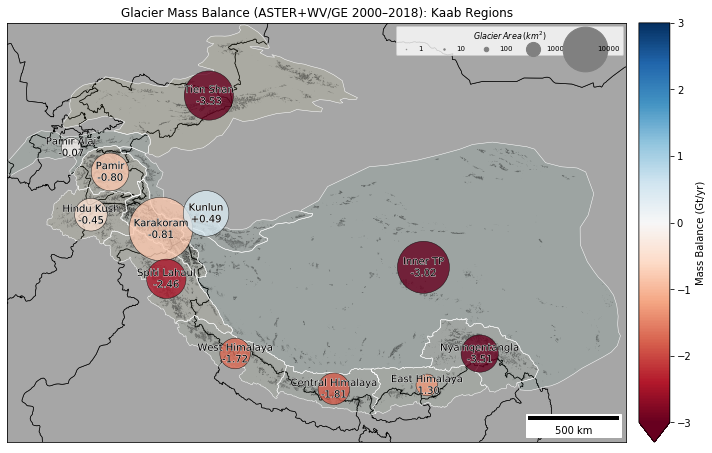

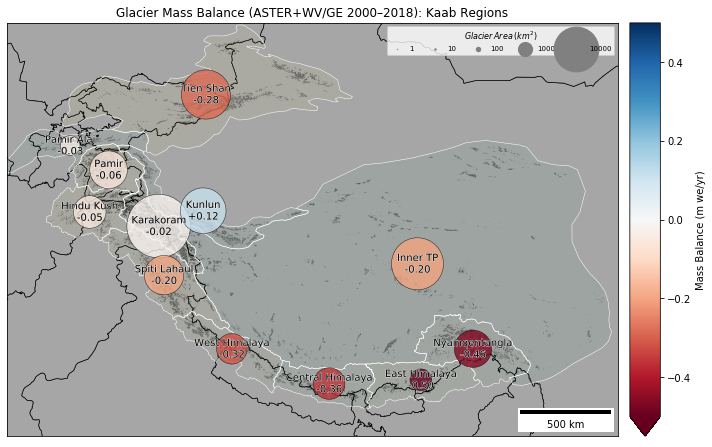

In [72]:
region_gt_clim = (-3.0, 3.0)
region_mb_clim=(-0.5, 0.5)

if map_plots and kaab_region_shp_fn is not None:
    kaab_region_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_kaab_region_Gt_fig.png'
    print("Generating figure: %s" % kaab_region_fig_fn)
    title = suptitle + ": Kaab Regions"
    #region_fig = make_map(col='mb_mwea', mb_dissolve_df=glac_df_mb_region, glac_df_mb=glac_df_mb, agg_df=region_df, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels='name+val')
    kaab_region_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_kaab_region, glac_df_mb=glac_df_mb, agg_df=kaab_region_df, border_df=border_df, clim=region_gt_clim, crs=crs, extent=extent, labels='name+val', title=title)
    print("Saving figure: %s" % kaab_region_fig_fn)
    kaab_region_fig.savefig(kaab_region_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 

    kaab_region_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_kaab_region_mwe_fig.png'
    print("Generating figure: %s" % kaab_region_fig_fn)
    title = suptitle + ": Kaab Regions"
    #region_fig = make_map(col='mb_mwea', mb_dissolve_df=glac_df_mb_region, glac_df_mb=glac_df_mb, agg_df=region_df, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels='name+val')
    kaab_region_fig = make_map(col=('mb_mwea', 'mean'), mb_dissolve_df=glac_df_mb_kaab_region, glac_df_mb=glac_df_mb, agg_df=kaab_region_df, border_df=border_df, clim=region_mb_clim, crs=crs, extent=extent, labels='name+val', title=title)
    print("Saving figure: %s" % kaab_region_fig_fn)
    kaab_region_fig.savefig(kaab_region_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 

Generating figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_region_Gt_fig.png
Plotting borders
Plotting agg boundaries
Plotting glacier polygons
Plotting scatterplot of ('mb_Gta', 'sum') values
Adding annotations
Saving figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_region_Gt_fig.png
Generating figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_region_mwe_fig.png
Plotting borders
Plotting agg boundaries
Plotting glacier polygons
Plotting scatterplot of ('mb_mwea', 'mean') values
Adding annotations
Saving figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_region_mwe_fig.png


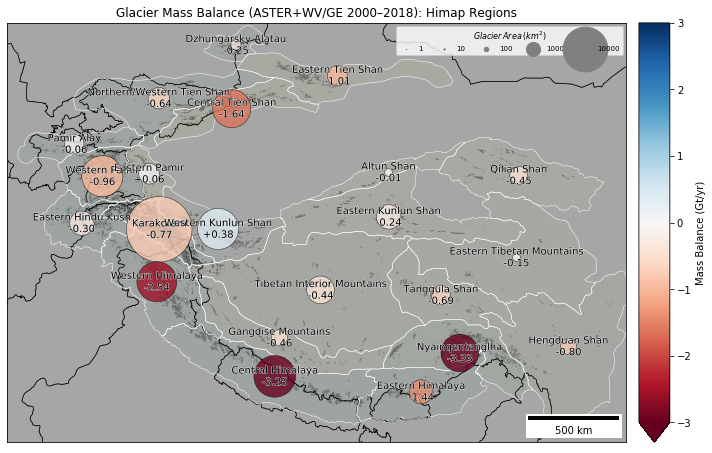

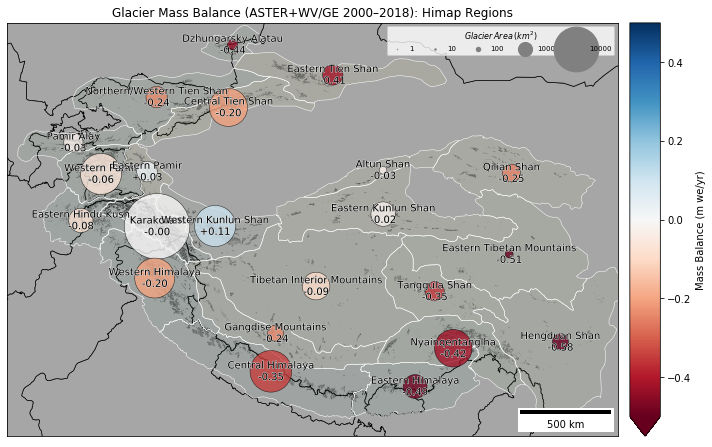

In [73]:
if map_plots and region_shp_fn is not None:
    region_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_region_Gt_fig.png'
    print("Generating figure: %s" % region_fig_fn)
    title = suptitle + ": Himap Regions"
    #region_fig = make_map(col='mb_mwea', mb_dissolve_df=glac_df_mb_region, glac_df_mb=glac_df_mb, agg_df=region_df, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels='name+val')
    region_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_region, glac_df_mb=glac_df_mb, agg_df=region_df, border_df=border_df, clim=region_gt_clim, crs=crs, extent=extent, labels='name+val', title=title)
    print("Saving figure: %s" % region_fig_fn)
    region_fig.savefig(region_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 

    region_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_region_mwe_fig.png'
    print("Generating figure: %s" % region_fig_fn)
    title = suptitle + ": Himap Regions"
    #region_fig = make_map(col='mb_mwea', mb_dissolve_df=glac_df_mb_region, glac_df_mb=glac_df_mb, agg_df=region_df, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels='name+val')
    region_fig = make_map(col=('mb_mwea', 'mean'), mb_dissolve_df=glac_df_mb_region, glac_df_mb=glac_df_mb, agg_df=region_df, border_df=border_df, clim=region_mb_clim, crs=crs, extent=extent, labels='name+val', title=title)
    print("Saving figure: %s" % region_fig_fn)
    region_fig.savefig(region_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 

Generating figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_mascon_mwe_fig.png
Plotting borders
Plotting glacier polygons
Plotting scatterplot of ('mb_mwea', 'mean') values
Saving figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_mascon_mwe_fig.png


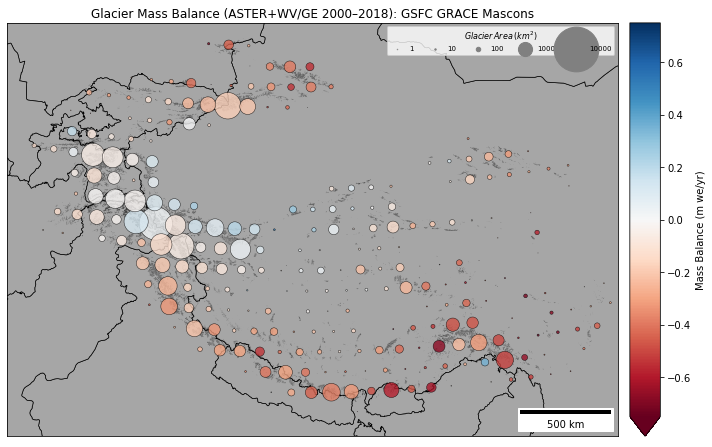

In [74]:
if map_plots and mascon_shp_fn is not None:
    mascon_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_mascon_mwe_fig.png'
    print("Generating figure: %s" % mascon_fig_fn)
    #To plot grid cells, pass agg_df=mascon_df
    title = suptitle + ": GSFC GRACE Mascons"
    mascon_fig = make_map(col=('mb_mwea', 'mean'), mb_dissolve_df=glac_df_mb_mascon, glac_df_mb=glac_df_mb, agg_df=None, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels=None, title=title)
    print("Saving figure: %s" % mascon_fig_fn)
    mascon_fig.savefig(mascon_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 

Generating figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_mascon_Gt_fig.png
Plotting borders
Plotting glacier polygons
Plotting scatterplot of ('mb_Gta', 'sum') values
Saving figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_mascon_Gt_fig.png


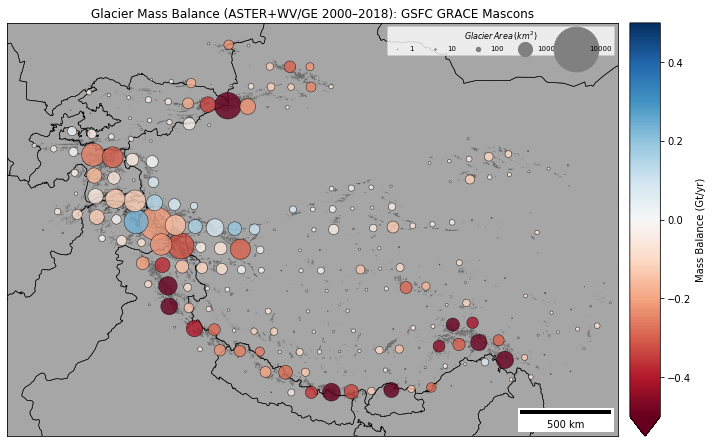

In [75]:
if map_plots and mascon_shp_fn is not None:
    mascon_gt_clim = (-0.5, 0.5)
    mascon_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_mascon_Gt_fig.png'
    print("Generating figure: %s" % mascon_fig_fn)
    #To plot grid cells, pass agg_df=mascon_df
    title = suptitle + ": GSFC GRACE Mascons"
    mascon_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_mascon, glac_df_mb=glac_df_mb, agg_df=None, border_df=border_df, clim=mascon_gt_clim, crs=crs, extent=extent, labels=None, title=title)
    print("Saving figure: %s" % mascon_fig_fn)
    mascon_fig.savefig(mascon_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 